# Capstone 2 Project: Modeling Traffic flow at Mill Road (UK)

### Statement: How can temporal data from traffic sensors be used to reasonably predict hourly traffic flow by looking at near term and long term patterns in Mill Road traffic data?

### Abstract:
Badly timed traffic lights can cause several problems like traffic congestion, dissatisfaction for drivers, dissatisfaction for drivers, increased risk of accidents and higher pollution. Many traffic controllers use real-time traffic data to time their signals. However these are often expensive to set up and operate.
One solution to this is implementing predictive models to time the signal, which will decrease dependence on real time sensor information, possibly eliminating the need for several sensors or allow cheaper sensors and reduce costs of installation and operation. 
<br>This project attempts to create such a model, using data from the Mill Road Project [https://data.world/datagov-uk/d3a76dbd-9936-4375-9ba6-e2974fafc943/workspace/project-summary?agentid=datagov-uk&datasetid=d3a76dbd-9936-4375-9ba6-e2974fafc943]. <br>This is hourly data for the flow of vehicles and pedestrians at the intersection.
<br>This data will be analyzed to develop a model that will predict the traffic for the next hour based on a combination of expected traffic from several days of data at the time, and recent traffic hourly data. This output can then be used to time the traffic signal appropriately.


## Conclusions

<li> We succesfully prepared and modeled the data for time series forecasting
<li> We compared the performance of two kinds of models, an ARIMA model and an XGBoost model
<li> We found the XGBoost model to have better forecasting capability than the ARIMA model for the dataset in question

## Initialization (imports and definitions)

In [1]:
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import tensorflow as tf
import scipy
from scipy.stats import linregress
from scipy.stats import pearsonr
from datetime import datetime, timedelta
import random
import sys
import os
from io import StringIO
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [2]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [3]:
# Class to create Plots grid

from itertools import product,cycle,combinations
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self,size_fac1,size_fac2):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(size_fac1*n_data_cols),int(size_fac2*n_rows)))
        
        # Flatten the axs array for easier iteration
        self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1,density=False):
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=df, y=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params(5,5)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            print(col)
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    def scatterplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Get all numeric combinations
        col_combinations = list(combinations(df.columns, 2))
        num_combs = len(col_combinations)
        
        # Calculate grid size based on the number of combinations
        n_cols = int(np.ceil(np.sqrt(num_combs)))
        n_rows = int(np.ceil(num_combs / n_cols))

        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2*n_cols),int(2.5*n_rows)))
        plt.suptitle('Pairwise Scatter with higher correlations shown brighter')
        axs = axs.flatten()  # Flatten the axes array for easier iteration

        # Iterate through each combination and plot scatterplots
        for i, (col_x, col_y) in enumerate(col_combinations):
            ax = axs[i]

            df_x_y=df[[col_x,col_y]].dropna()

            x = df_x_y[col_x]
            y = df_x_y[col_y]

            # Calculate Pearson correlation and p-value
            if len(x) > 1 and len(y) > 1:  # Ensure there are enough data points
                corr, p_value = pearsonr(x, y)
                corr_array=np.array([corr]*x.shape[0])
                # Scatter plot with colored points
                sns.scatterplot(x=x, y=y, ax=ax,hue=corr_array, palette='coolwarm',hue_norm=(-1,1),legend=False)

                # Add correlation coefficient and p-value as the legend
                ax.text(0.05, 0.95, f"r = {corr:.2f}\np = {p_value:.2e}", 
                        transform=ax.transAxes, fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))
                
                # Set plot labels
                ax.set_xlabel(col_x)
                ax.set_ylabel(col_y)

        # Hide any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
        plt.tight_layout()
        plt.show()

## Data Extraction

In [4]:
#data_url='https://query.data.world/s/wj2wwszc2ldqikthjxld4zazaayexw?dws=00000'
# Import
#df=pd.read_csv(data_url)
df=pd.read_csv('mill_road_traffic_data.csv',index_col=0)
df.head()

Local Time (Sensor)        Date      Time  \
0    03/06/2019 01:00  03/06/2019  01:00:00   
1    03/06/2019 01:00  03/06/2019  01:00:00   
2    03/06/2019 01:00  03/06/2019  01:00:00   
3    03/06/2019 01:00  03/06/2019  01:00:00   
4    03/06/2019 01:00  03/06/2019  01:00:00   

                         countlineName direction  Car  Pedestrian  Cyclist  \
0                  S10_EastRoad_CAM003        in   89           9        4   
1                  S10_EastRoad_CAM003       out   51           6        0   
2  S12_DevonshireRoad_CyclePath_CAM003        in    0           0        0   
3  S12_DevonshireRoad_CyclePath_CAM003       out    0           2        0   
4                S13_MiltonRoad_CAM003        in   66           2        5   

   Motorbike  Bus  OGV1  OGV2  LGV  
0          2    1     0     0    5  
1          0    0     1     0    1  
2          0    0     0     0    0  
3          0    0     0     0    0  
4          4    0     0     0    4

In [5]:
df_sensors=df.copy()

In [6]:
# Location information
df_loc=pd.read_csv('mill-road-trial-sensor-point-locations-2.csv')
df_loc

Sensor Reference      Sensor Type              Street location  \
0                  1  Vivacity sensor                  362 Mill Rd   
1                  2  Vivacity sensor  Mill Rd (SO 1 Mortimer Rd)    
2                  3  Vivacity sensor             108 Coleridge Rd   
3                  4  Vivacity sensor                114 Vinery Rd   
4                  5  Vivacity sensor                 2 Tenison Rd   
5                  6  Vivacity sensor              OP 6 Station Rd   
6                  7  Vivacity sensor          151/153 Coldhams Ln   
7                  8  Vivacity sensor         117 Cherry Hinton Rd   
8                 10  Vivacity sensor               142 Perne Road   
9                 11  Vivacity sensor            O/S ARU East Road   
10                12  Vivacity sensor               41 Histon Road   
11                13  Vivacity sensor             55 Devonshire Rd   
12                14  Vivacity sensor                214 Milton Rd   
13                15  Vivacity sensor                 140 Hills Rd   
14                16  Vivacity sensor           560 Newmarket Road   

   Column number    Easting  Northing  
0          L6RAS  52.196510  0.153030  
1         L62RAS  52.201920  0.132450  
2         L10RCI  52.190930  0.145920  
3         L11RJJ  52.199990  0.152570  
4      L1SAI (1)  52.199940  0.136790  
5          L2SAO  52.194855  0.132876  
6         L36RJD  52.203770  0.152010  
7         L13RCH  52.188320  0.142270  
8         L21RIW  52.192390  0.154670  
9         L29RBS  52.204070  0.132940  
10         L6WAS  52.215610  0.110890  
11        L11RCD  52.196240  0.137130  
12        L37RCG  52.220630  0.134160  
13  L58SAN (39A)  52.190080  0.135340  
14       L104RCA  52.212880  0.156740

## Exploratory Data Analysis and Feature Engineering

Create Geolocator using Nominatim and Obtain Location info. for the places

In [7]:
geoagent="explorer"
geolocator = Nominatim(user_agent=geoagent)

In [8]:
# Location for city
city='London, United Kingdom'
loc=geolocator.geocode(city)
latitude=loc.latitude
longitude=loc.longitude
latitude,longitude

(51.5074456, -0.1277653)

In [9]:
# Rename the 'Easting' and 'Northing' columns to 'Sensor Latitude' and 'Sensor Longitude'
df_loc.rename(columns={'Easting':'Sensor Latitude','Northing':'Sensor Longitude'},inplace=True)

In [10]:
df_loc.head(1)

Sensor Reference      Sensor Type Street location Column number  \
0                 1  Vivacity sensor     362 Mill Rd         L6RAS   

   Sensor Latitude  Sensor Longitude  
0         52.19651           0.15303

Visualize sensors on map

In [11]:
# Sensor distribution on map
latitude=np.median(df_loc['Sensor Latitude'])
longitude=np.median(df_loc['Sensor Longitude'])

map_clusters = folium.Map(location=[latitude, longitude],zoom_start=12)

for index,row in df_loc.iterrows():

    num,street,lat,lon=row['Sensor Reference'],row['Street location'],row['Sensor Latitude'],row['Sensor Longitude']
    label = folium.Popup(f"{num}, Street: {street}", parse_html=True)

    folium.RegularPolygonMarker(
        [lat, lon],
        radius=7,
        number_of_sides=5,
        popup=label,
        color='red',
        fill=True,
        fill_color=None,
        fill_opacity=0.7,
                        ).add_to(map_clusters)

map_clusters

In [12]:
# Make a list of sensor names
sensors_list=df_sensors.countlineName.unique().tolist()
sensors_list

['S10_EastRoad_CAM003',
 'S12_DevonshireRoad_CyclePath_CAM003',
 'S13_MiltonRoad_CAM003',
 'S14_HillsRoad_CAM003',
 'S15_NewmarketRoad_CAM003',
 'S16_PerneRoad_CAM003',
 'S18_MIltonRd_Ped_Path_RHS_CAM004',
 'S18_MiltonRd_CAM004',
 'S18_MiltonRd_Ped_Path_LHS_CAM004',
 'S19_MiltonRd_CAM004',
 'S19_MiltonRd_Ped_Path_RHS_CAM004',
 'S19_MiltonRd_Ped_path_LHS_CAM004',
 'S1_MillRoad_CAM003',
 'S20_CambridgeRd_CAM004',
 'S20_CambridgeRd_Ped_Path_LHS_CAM004',
 'S20_CambridgeRd_Ped_Path_RHS_CAM004',
 'S21_HistonRd_CAM004',
 'S21_HistonRd_Ped_Path_RHS_CAM004',
 'S21_HistonRd_Pedestrian_LHS_CAM004',
 'S2_MillRoad_CAM003',
 'S3_ColeridgeRoad_CAM003',
 'S4_VineryRoad_CAM003',
 'S5_TenisonRoad_CAM003',
 'S6_StationRoad_CAM003',
 'S7_ColdhamsLane_CAM003',
 'S8_CherryHintonRoad_CAM003',
 's24_hills_road_Ped_RHS_cam005',
 's24_hills_road_cam005',
 's25_hills-road_ped_LHS_cam005',
 's25_wulfstan_way_cam005',
 's25_wulfstan_way_ped_LHS_cam005',
 's25_wulfstan_way_ped_RHS_cam005',
 's26_nightinagle_avenue_

### Analyse the time deltas

In [13]:
df_sensors.Time.unique()

array(['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
       '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00',
       '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00',
       '21:00:00', '22:00:00', '23:00:00', '00:00:00'], dtype=object)

The timestamps are in hours, which is what is expected since the data was mentioned to be hourly

In [14]:
# Since the times are in hours only, we can create an 'hour' column by extracting the first two characters of the string and converting to int
df_sensors['hour']=df_sensors.Time.apply(lambda x:int(x[:2]))
df_sensors.head()

Local Time (Sensor)        Date      Time  \
0    03/06/2019 01:00  03/06/2019  01:00:00   
1    03/06/2019 01:00  03/06/2019  01:00:00   
2    03/06/2019 01:00  03/06/2019  01:00:00   
3    03/06/2019 01:00  03/06/2019  01:00:00   
4    03/06/2019 01:00  03/06/2019  01:00:00   

                         countlineName direction  Car  Pedestrian  Cyclist  \
0                  S10_EastRoad_CAM003        in   89           9        4   
1                  S10_EastRoad_CAM003       out   51           6        0   
2  S12_DevonshireRoad_CyclePath_CAM003        in    0           0        0   
3  S12_DevonshireRoad_CyclePath_CAM003       out    0           2        0   
4                S13_MiltonRoad_CAM003        in   66           2        5   

   Motorbike  Bus  OGV1  OGV2  LGV  hour  
0          2    1     0     0    5     1  
1          0    0     1     0    1     1  
2          0    0     0     0    0     1  
3          0    0     0     0    0     1  
4          4    0     0     0    4     1

In [15]:
# Add a column for total traffic
df_sensors['Total']=df_sensors[['Car',	'Pedestrian',	'Cyclist',	'Motorbike',	'Bus',	'OGV1',	'OGV2',	'LGV']].sum(axis=1)
df_sensors.head()

Local Time (Sensor)        Date      Time  \
0    03/06/2019 01:00  03/06/2019  01:00:00   
1    03/06/2019 01:00  03/06/2019  01:00:00   
2    03/06/2019 01:00  03/06/2019  01:00:00   
3    03/06/2019 01:00  03/06/2019  01:00:00   
4    03/06/2019 01:00  03/06/2019  01:00:00   

                         countlineName direction  Car  Pedestrian  Cyclist  \
0                  S10_EastRoad_CAM003        in   89           9        4   
1                  S10_EastRoad_CAM003       out   51           6        0   
2  S12_DevonshireRoad_CyclePath_CAM003        in    0           0        0   
3  S12_DevonshireRoad_CyclePath_CAM003       out    0           2        0   
4                S13_MiltonRoad_CAM003        in   66           2        5   

   Motorbike  Bus  OGV1  OGV2  LGV  hour  Total  
0          2    1     0     0    5     1    110  
1          0    0     1     0    1     1     59  
2          0    0     0     0    0     1      0  
3          0    0     0     0    0     1      2  
4          4    0     0     0    4     1     81

In [16]:
# First split the 'out' and 'in' into separate datasets then merge on 'Local Time (Sensor)' to get both out and in information at a given timestamp
df_sensors_in=df_sensors[df_sensors.direction=='in']
df_sensors_out=df_sensors[df_sensors.direction=='out'].drop(columns=['Date','Time','direction','hour'])

In [17]:
df_sensors_in.head()

Local Time (Sensor)        Date      Time  \
0    03/06/2019 01:00  03/06/2019  01:00:00   
2    03/06/2019 01:00  03/06/2019  01:00:00   
4    03/06/2019 01:00  03/06/2019  01:00:00   
6    03/06/2019 01:00  03/06/2019  01:00:00   
8    03/06/2019 01:00  03/06/2019  01:00:00   

                         countlineName direction  Car  Pedestrian  Cyclist  \
0                  S10_EastRoad_CAM003        in   89           9        4   
2  S12_DevonshireRoad_CyclePath_CAM003        in    0           0        0   
4                S13_MiltonRoad_CAM003        in   66           2        5   
6                 S14_HillsRoad_CAM003        in   38           0        3   
8             S15_NewmarketRoad_CAM003        in   47           1        0   

   Motorbike  Bus  OGV1  OGV2  LGV  hour  Total  
0          2    1     0     0    5     1    110  
2          0    0     0     0    0     1      0  
4          4    0     0     0    4     1     81  
6          2    0     1     0    0     1     44  
8          0    0     0     0    3     1     51

In [18]:
df_sensors_out.head()

Local Time (Sensor)                        countlineName  Car  Pedestrian  \
1    03/06/2019 01:00                  S10_EastRoad_CAM003   51           6   
3    03/06/2019 01:00  S12_DevonshireRoad_CyclePath_CAM003    0           2   
5    03/06/2019 01:00                S13_MiltonRoad_CAM003   36           2   
7    03/06/2019 01:00                 S14_HillsRoad_CAM003   39           5   
9    03/06/2019 01:00             S15_NewmarketRoad_CAM003   63           0   

   Cyclist  Motorbike  Bus  OGV1  OGV2  LGV  Total  
1        0          0    0     1     0    1     59  
3        0          0    0     0     0    0      2  
5        0          0    1     0     0    3     42  
7        0          0    1     0     0    1     46  
9        0          1    1     0     0    2     67

### Combine and in and out DFs into one dataframe showing all traffic for a given time

In [19]:
df_sensors_in_out=df_sensors_in.merge(df_sensors_out,on=['Local Time (Sensor)','countlineName'],suffixes=('_in', '_out'))
df_sensors_in_out.head()

Local Time (Sensor)        Date      Time  \
0    03/06/2019 01:00  03/06/2019  01:00:00   
1    03/06/2019 01:00  03/06/2019  01:00:00   
2    03/06/2019 01:00  03/06/2019  01:00:00   
3    03/06/2019 01:00  03/06/2019  01:00:00   
4    03/06/2019 01:00  03/06/2019  01:00:00   

                         countlineName direction  Car_in  Pedestrian_in  \
0                  S10_EastRoad_CAM003        in      89              9   
1  S12_DevonshireRoad_CyclePath_CAM003        in       0              0   
2                S13_MiltonRoad_CAM003        in      66              2   
3                 S14_HillsRoad_CAM003        in      38              0   
4             S15_NewmarketRoad_CAM003        in      47              1   

   Cyclist_in  Motorbike_in  Bus_in  ...  Total_in  Car_out  Pedestrian_out  \
0           4             2       1  ...       110       51               6   
1           0             0       0  ...         0        0               2   
2           5             4       0  ...        81       36               2   
3           3             2       0  ...        44       39               5   
4           0             0       0  ...        51       63               0   

   Cyclist_out  Motorbike_out  Bus_out  OGV1_out  OGV2_out  LGV_out  Total_out  
0            0              0        0         1         0        1         59  
1            0              0        0         0         0        0          2  
2            0              0        1         0         0        3         42  
3            0              0        1         0         0        1         46  
4            0              1        1         0         0        2         67  

[5 rows x 24 columns]

In [20]:
# Add a column for total in-out
df_sensors_in_out['Total_in_minus_out']=df_sensors_in_out['Total_in']-df_sensors_in_out['Total_out']

In [21]:
# Isolate to one street name, EastRoad
df_sensors_in_out[df_sensors_in_out['countlineName'].str.contains('EastRoad')]['countlineName'].unique()

array(['S10_EastRoad_CAM003'], dtype=object)

In [22]:
# Isolate the data to one sensor
df_sensors_in_out[df_sensors_in_out.countlineName==sensors_list[0]].head()

Local Time (Sensor)        Date      Time        countlineName direction  \
0      03/06/2019 01:00  03/06/2019  01:00:00  S10_EastRoad_CAM003        in   
45     03/06/2019 02:00  03/06/2019  02:00:00  S10_EastRoad_CAM003        in   
90     03/06/2019 03:00  03/06/2019  03:00:00  S10_EastRoad_CAM003        in   
135    03/06/2019 04:00  03/06/2019  04:00:00  S10_EastRoad_CAM003        in   
180    03/06/2019 05:00  03/06/2019  05:00:00  S10_EastRoad_CAM003        in   

     Car_in  Pedestrian_in  Cyclist_in  Motorbike_in  Bus_in  ...  Car_out  \
0        89              9           4             2       1  ...       51   
45       34              4           1             0       0  ...       32   
90       42              3           2             0       0  ...       38   
135      39              2           8             2       0  ...       68   
180      85              2           9             1       1  ...      119   

     Pedestrian_out  Cyclist_out  Motorbike_out  Bus_out  OGV1_out  OGV2_out  \
0                 6            0              0        0         1         0   
45                5            0              0        1         0         0   
90                0            1              0        0         1         0   
135               9            5              3        1         1         0   
180               8           19              4        1         5         0   

     LGV_out  Total_out  Total_in_minus_out  
0          1         59                  51  
45         5         43                   1  
90         6         46                   7  
135       16        103                 -47  
180       34        190                 -73  

[5 rows x 25 columns]

In [23]:
df_sensors_in_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262530 entries, 0 to 262529
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Local Time (Sensor)  262530 non-null  object
 1   Date                 262530 non-null  object
 2   Time                 262530 non-null  object
 3   countlineName        262530 non-null  object
 4   direction            262530 non-null  object
 5   Car_in               262530 non-null  int64 
 6   Pedestrian_in        262530 non-null  int64 
 7   Cyclist_in           262530 non-null  int64 
 8   Motorbike_in         262530 non-null  int64 
 9   Bus_in               262530 non-null  int64 
 10  OGV1_in              262530 non-null  int64 
 11  OGV2_in              262530 non-null  int64 
 12  LGV_in               262530 non-null  int64 
 13  hour                 262530 non-null  int64 
 14  Total_in             262530 non-null  int64 
 15  Car_out              262530 non-nu

In [24]:
# Print maximum date
df_sensors_in_out['Date'].max()

'31/12/2019'

In [25]:
# Since it is in dd/mm/yyyy format, convert Local time to pandas datetime object using this format
df_sensors_in_out['Local Time (Sensor)']=df_sensors_in_out['Local Time (Sensor)'].apply(pd.to_datetime,dayfirst=True)
df_sensors_in_out['Local Time (Sensor)'][:5]

0   2019-06-03 01:00:00
1   2019-06-03 01:00:00
2   2019-06-03 01:00:00
3   2019-06-03 01:00:00
4   2019-06-03 01:00:00
Name: Local Time (Sensor), dtype: datetime64[ns]

In [26]:
df_sensors_in_out=df_sensors_in_out.set_index('Local Time (Sensor)')
df_sensors_in_out.head()

Date      Time  \
Local Time (Sensor)                         
2019-06-03 01:00:00  03/06/2019  01:00:00   
2019-06-03 01:00:00  03/06/2019  01:00:00   
2019-06-03 01:00:00  03/06/2019  01:00:00   
2019-06-03 01:00:00  03/06/2019  01:00:00   
2019-06-03 01:00:00  03/06/2019  01:00:00   

                                           countlineName direction  Car_in  \
Local Time (Sensor)                                                          
2019-06-03 01:00:00                  S10_EastRoad_CAM003        in      89   
2019-06-03 01:00:00  S12_DevonshireRoad_CyclePath_CAM003        in       0   
2019-06-03 01:00:00                S13_MiltonRoad_CAM003        in      66   
2019-06-03 01:00:00                 S14_HillsRoad_CAM003        in      38   
2019-06-03 01:00:00             S15_NewmarketRoad_CAM003        in      47   

                     Pedestrian_in  Cyclist_in  Motorbike_in  Bus_in  OGV1_in  \
Local Time (Sensor)                                                             
2019-06-03 01:00:00              9           4             2       1        0   
2019-06-03 01:00:00              0           0             0       0        0   
2019-06-03 01:00:00              2           5             4       0        0   
2019-06-03 01:00:00              0           3             2       0        1   
2019-06-03 01:00:00              1           0             0       0        0   

                     ...  Car_out  Pedestrian_out  Cyclist_out  Motorbike_out  \
Local Time (Sensor)  ...                                                        
2019-06-03 01:00:00  ...       51               6            0              0   
2019-06-03 01:00:00  ...        0               2            0              0   
2019-06-03 01:00:00  ...       36               2            0              0   
2019-06-03 01:00:00  ...       39               5            0              0   
2019-06-03 01:00:00  ...       63               0            0              1   

                     Bus_out  OGV1_out  OGV2_out  LGV_out  Total_out  \
Local Time (Sensor)                                                    
2019-06-03 01:00:00        0         1         0        1         59   
2019-06-03 01:00:00        0         0         0        0          2   
2019-06-03 01:00:00        1         0         0        3         42   
2019-06-03 01:00:00        1         0         0        1         46   
2019-06-03 01:00:00        1         0         0        2         67   

                     Total_in_minus_out  
Local Time (Sensor)                      
2019-06-03 01:00:00                  51  
2019-06-03 01:00:00                  -2  
2019-06-03 01:00:00                  39  
2019-06-03 01:00:00                  -2  
2019-06-03 01:00:00                 -16  

[5 rows x 24 columns]

### Isolate for one sensor 

In [27]:
sensor=sensors_list[0]

In [28]:
df_sensors_in_out_sensor=df_sensors_in_out[df_sensors_in_out.countlineName==sensor]

### Explore the data for that sensor

In [29]:
# Create numeric columns and text columns
numeric_cols=df_sensors_in_out_sensor.select_dtypes(include=['number']).columns 
categorical_cols=df_sensors_in_out_sensor.select_dtypes(include=['object']).columns 

In [30]:
df_sensors_in_out_sensor_numeric=df_sensors_in_out_sensor[numeric_cols]
df_sensors_in_out_sensor_numeric.head(2)

Car_in  Pedestrian_in  Cyclist_in  Motorbike_in  Bus_in  \
Local Time (Sensor)                                                            
2019-06-03 01:00:00      89              9           4             2       1   
2019-06-03 02:00:00      34              4           1             0       0   

                     OGV1_in  OGV2_in  LGV_in  hour  Total_in  Car_out  \
Local Time (Sensor)                                                      
2019-06-03 01:00:00        0        0       5     1       110       51   
2019-06-03 02:00:00        0        0       5     2        44       32   

                     Pedestrian_out  Cyclist_out  Motorbike_out  Bus_out  \
Local Time (Sensor)                                                        
2019-06-03 01:00:00               6            0              0        0   
2019-06-03 02:00:00               5            0              0        1   

                     OGV1_out  OGV2_out  LGV_out  Total_out  \
Local Time (Sensor)                                           
2019-06-03 01:00:00         1         0        1         59   
2019-06-03 02:00:00         0         0        5         43   

                     Total_in_minus_out  
Local Time (Sensor)                      
2019-06-03 01:00:00                  51  
2019-06-03 02:00:00                   1

In [31]:
df_sensors_in_out_sensor_categorical=df_sensors_in_out_sensor[categorical_cols]
df_sensors_in_out_sensor_categorical.head(2)

Date      Time        countlineName direction
Local Time (Sensor)                                                     
2019-06-03 01:00:00  03/06/2019  01:00:00  S10_EastRoad_CAM003        in
2019-06-03 02:00:00  03/06/2019  02:00:00  S10_EastRoad_CAM003        in

### Look at the distribution of numeric features

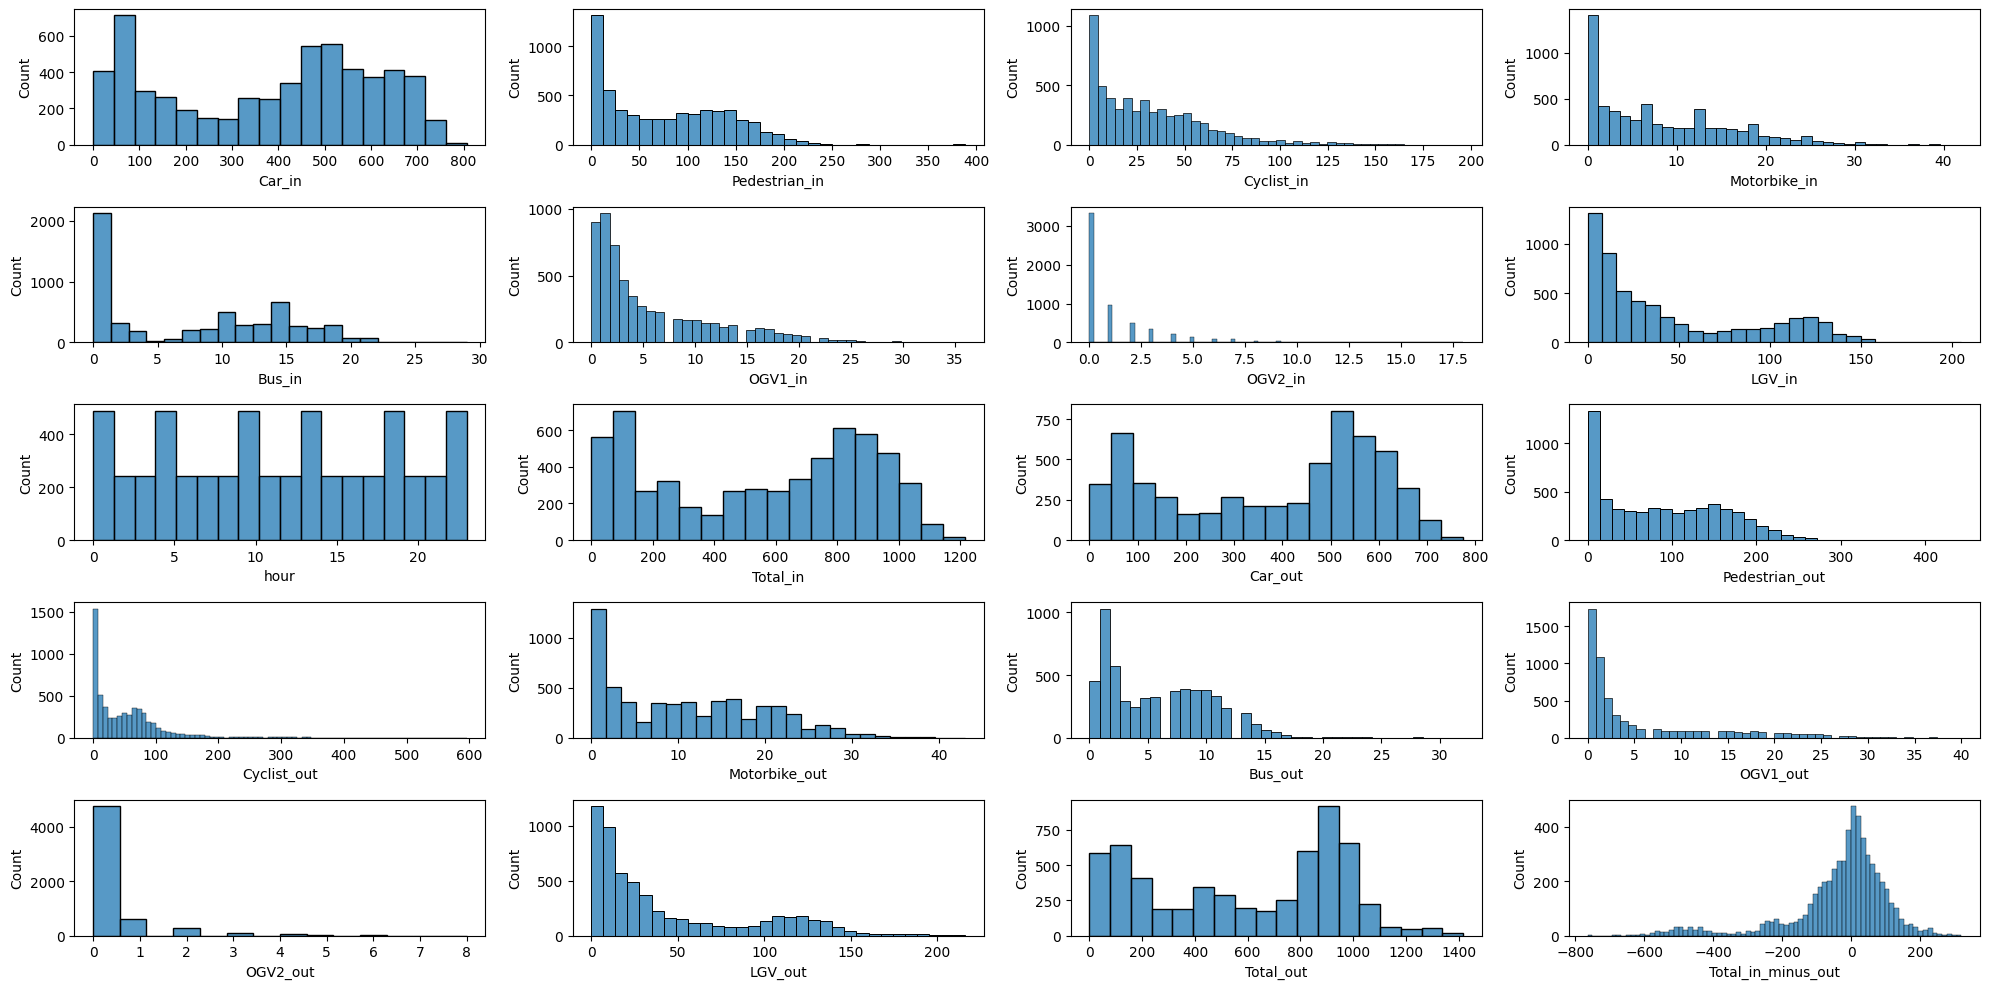

In [32]:
Plotsgrid(df_sensors_in_out_sensor_numeric).histplots()

<b> Observations: </b>
<p>
<ol>
<li>  Upto 800 cars travel in and out of the intersection in an hour. The distribution appears to be bimodal, with peaks around roughly 70 ad 550 respectively, this could be due to different times of day, or times of year, or both. 
<li> Most kinds of traffic have their peak frequency close to zero, which makes sense because traffic will be light during the night hours. Cars are the exception to this indicating that this mode of transportation is active for more hours throughout the day
<li> Looks like certain hours are more heavily represented in the data than others; this could potentially make the data more accurate for those hours than others, and might need to be managed in the analysis
<li> It'd be expected to have as much traffic leaving the intersection at any given hour as entering. While the total_in_minus_out's mean of zero makes sense, it's left skewed distribution (more traffic leaving than entering?) and wide tails do not. This should be further explored
</ol>
</p>
<p>
East 10, where this sensor is located, seems to be a rather busy intersection with lots of different kinds of traffic!
</p>

### Explore the in-out question

In [33]:
df_sensors_in_out_sensor_numeric.describe()

Car_in  Pedestrian_in   Cyclist_in  Motorbike_in       Bus_in  \
count  5834.000000    5834.000000  5834.000000   5834.000000  5834.000000   
mean    379.682379      76.601474    32.065821      8.172095     7.759685   
std     226.594141      62.135311    29.107905      7.502731     6.970181   
min       0.000000       0.000000     0.000000      0.000000     0.000000   
25%     142.000000      15.000000     7.000000      2.000000     1.000000   
50%     439.000000      69.000000    26.000000      6.000000     8.500000   
75%     565.000000     128.000000    48.000000     13.000000    14.000000   
max     807.000000     388.000000   196.000000     42.000000    29.000000   

           OGV1_in      OGV2_in       LGV_in         hour     Total_in  \
count  5834.000000  5834.000000  5834.000000  5834.000000  5834.000000   
mean      5.659068     1.245972    45.634727    11.496572   556.821220   
std       6.068144     2.163948    44.890908     6.924050   344.320145   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     9.000000     5.000000   188.250000   
50%       3.000000     0.000000    27.000000    11.000000   630.000000   
75%       9.000000     2.000000    82.000000    17.000000   860.000000   
max      36.000000    18.000000   205.000000    23.000000  1216.000000   

           Car_out  Pedestrian_out  Cyclist_out  Motorbike_out      Bus_out  \
count  5834.000000     5834.000000  5834.000000    5834.000000  5834.000000   
mean    380.803051       89.255399    52.549194      10.827905     5.931094   
std     216.073846       70.401741    59.434933       8.916659     4.694440   
min       0.000000        0.000000     0.000000       0.000000     0.000000   
25%     148.000000       17.000000     7.000000       2.000000     1.000000   
50%     460.000000       82.000000    39.000000      10.000000     6.000000   
75%     561.000000      148.000000    77.000000      18.000000     9.000000   
max     775.000000      443.000000   596.000000      43.000000    32.000000   

          OGV1_out     OGV2_out      LGV_out    Total_out  Total_in_minus_out  
count  5834.000000  5834.000000  5834.000000  5834.000000         5834.000000  
mean      5.523654     0.318306    43.987659   589.196263          -32.375043  
std       7.638601     0.807973    46.554089   364.840815          145.091074  
min       0.000000     0.000000     0.000000     0.000000         -764.000000  
25%       0.000000     0.000000     8.000000   198.000000          -75.000000  
50%       2.000000     0.000000    23.000000   662.000000            0.000000  
75%       8.000000     0.000000    71.000000   913.000000           51.000000  
max      40.000000     8.000000   216.000000  1417.000000          320.000000

In [34]:
# Let's filter for the data where in-out is high
df_abnormal_traf_flow=df_sensors_in_out_sensor_numeric[abs(df_sensors_in_out_sensor_numeric['Total_in_minus_out'])>50]
df_abnormal_traf_flow.head()

Car_in  Pedestrian_in  Cyclist_in  Motorbike_in  Bus_in  \
Local Time (Sensor)                                                            
2019-06-03 01:00:00      89              9           4             2       1   
2019-06-03 05:00:00      85              2           9             1       1   
2019-06-03 06:00:00     161             13          31             1       1   
2019-06-03 07:00:00     319             34          22             6      11   
2019-06-03 08:00:00     472             85          47             7      17   

                     OGV1_in  OGV2_in  LGV_in  hour  Total_in  Car_out  \
Local Time (Sensor)                                                      
2019-06-03 01:00:00        0        0       5     1       110       51   
2019-06-03 05:00:00        3        1      15     5       117      119   
2019-06-03 06:00:00        6        3      35     6       251      303   
2019-06-03 07:00:00       12        6      86     7       496      561   
2019-06-03 08:00:00       11        7      85     8       731      588   

                     Pedestrian_out  Cyclist_out  Motorbike_out  Bus_out  \
Local Time (Sensor)                                                        
2019-06-03 01:00:00               6            0              0        0   
2019-06-03 05:00:00               8           19              4        1   
2019-06-03 06:00:00              27           38             13        5   
2019-06-03 07:00:00              90          137             21        4   
2019-06-03 08:00:00             164          314             15        4   

                     OGV1_out  OGV2_out  LGV_out  Total_out  \
Local Time (Sensor)                                           
2019-06-03 01:00:00         1         0        1         59   
2019-06-03 05:00:00         5         0       34        190   
2019-06-03 06:00:00        13         1       58        458   
2019-06-03 07:00:00        11         1      141        966   
2019-06-03 08:00:00        21         2      136       1244   

                     Total_in_minus_out  
Local Time (Sensor)                      
2019-06-03 01:00:00                  51  
2019-06-03 05:00:00                 -73  
2019-06-03 06:00:00                -207  
2019-06-03 07:00:00                -470  
2019-06-03 08:00:00                -513

Nothing obvious about why the flow could be negative. <br>Are there multiple sensors at this location that each capture a certain portion? Maybe the entire flow is caught by all sixteen sensors. Instead of looking at one sensor, lets look at the data distributions for all of them.

In [35]:
(df_sensors_in_out[['Total_in','Total_out','Total_in_minus_out']]).describe()

Total_in      Total_out  Total_in_minus_out
count  262530.000000  262530.000000       262530.000000
mean      115.570358     125.563414           -9.993056
std       216.528729     239.156390           78.719554
min         0.000000       0.000000        -1071.000000
25%         0.000000       0.000000           -3.000000
50%         0.000000       0.000000            0.000000
75%       118.000000     128.000000            0.000000
max      1246.000000    1912.000000          716.000000

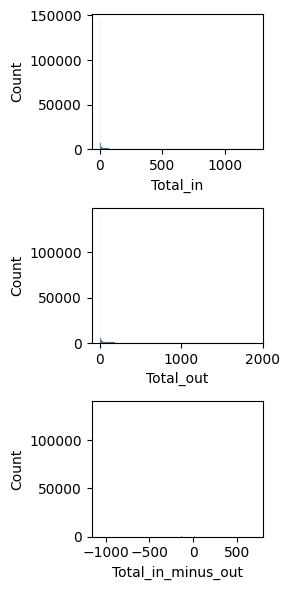

In [36]:
Plotsgrid(df_sensors_in_out[['Total_in','Total_out','Total_in_minus_out']]).histplots()

<li> This gives a much more reasonable picture. The net flow across all sensors is close to zero and roughly equal amounts of traffic enter and leave (in and out). 
<li>While not mentioned directly in the source, it is possible that 'in and 'out' correspond to each direction of a two-way street, so they could have different numbers.
<li> Referring back to the sensors map from earlier, this might explain why while the net flow for each sensor is not zero, the flow across all sixteen sensors that span most of the roads going into or out of the area would have a net flow of zero
<p><b>
<br> Therefore, it seems we should focus on data from all sensors. This would model a real intersection better where traffic is multi-directional and net flow is close to zero <b>

## Variable Selection

<i> What variable to focus on? </i>
<br> A real world traffic signal will probably time based on the <i>traffic outflow</i>. 
<br> Traffic enters the intersection with the goal of leaving. If outflow drops to a low level (for example blocked traffic or even very little traffic), the signal might need to be timed more frequently to avoid traffic delay. 
<br> However too frequent timing can cause the intersection to be overwhelmed and the traffic to become disorderly.
<br> Therefore, we can choose '<b>Total_out</b>' as our dependent (target) variable

## Data Preparation

Since there are multiple sensor values at the same timestamp and we are interested in the total, we should sum the values at each timestamp. This will also give us a smaller array size that will be easier to work with

In [37]:
# Create aggregation dictionary (aggregate hour to mean and others to sum)
agg_dict = {col:'sum' if col != 'hour' else 'mean' for col in numeric_cols}
# Group by Local time using aggregation dictionary
df_sensors_in_out_timegrouped=df_sensors_in_out.groupby(by='Local Time (Sensor)').agg(agg_dict).sort_index()
df_sensors_in_out_timegrouped.head()

Car_in  Pedestrian_in  Cyclist_in  Motorbike_in  Bus_in  \
Local Time (Sensor)                                                            
2019-06-03 01:00:00     565             40          25            14       1   
2019-06-03 02:00:00     388             27          12             1       0   
2019-06-03 03:00:00     388             11          10             3       0   
2019-06-03 04:00:00     297             10          26             9       4   
2019-06-03 05:00:00     580             23          71            16       4   

                     OGV1_in  OGV2_in  LGV_in  hour  Total_in  Car_out  \
Local Time (Sensor)                                                      
2019-06-03 01:00:00        1        0      25   1.0       671      695   
2019-06-03 02:00:00        3        1      25   2.0       457      731   
2019-06-03 03:00:00        1        0      24   3.0       437      685   
2019-06-03 04:00:00        9        1      38   4.0       394      397   
2019-06-03 05:00:00       10        8     105   5.0       817      764   

                     Pedestrian_out  Cyclist_out  Motorbike_out  Bus_out  \
Local Time (Sensor)                                                        
2019-06-03 01:00:00              40           10              4        4   
2019-06-03 02:00:00              26            4              1        2   
2019-06-03 03:00:00              20            8              1        2   
2019-06-03 04:00:00              66           50              8        3   
2019-06-03 05:00:00              91          130             26        5   

                     OGV1_out  OGV2_out  LGV_out  Total_out  \
Local Time (Sensor)                                           
2019-06-03 01:00:00         1         0       13        767   
2019-06-03 02:00:00         1         0       16        781   
2019-06-03 03:00:00         1         1       18        736   
2019-06-03 04:00:00         5         0       44        573   
2019-06-03 05:00:00        19         5      133       1173   

                     Total_in_minus_out  
Local Time (Sensor)                      
2019-06-03 01:00:00                 -96  
2019-06-03 02:00:00                -324  
2019-06-03 03:00:00                -299  
2019-06-03 04:00:00                -179  
2019-06-03 05:00:00                -356

In [38]:
# Check for first timestamp
first_timestamp=df_sensors_in_out.index[0]
df_sensors_in_out.loc[first_timestamp,numeric_cols].sum(axis=0)-df_sensors_in_out_timegrouped.head(1)

Car_in  Pedestrian_in  Cyclist_in  Motorbike_in  Bus_in  \
Local Time (Sensor)                                                            
2019-06-03 01:00:00       0              0           0             0       0   

                     OGV1_in  OGV2_in  LGV_in  hour  Total_in  Car_out  \
Local Time (Sensor)                                                      
2019-06-03 01:00:00        0        0       0  44.0         0        0   

                     Pedestrian_out  Cyclist_out  Motorbike_out  Bus_out  \
Local Time (Sensor)                                                        
2019-06-03 01:00:00               0            0              0        0   

                     OGV1_out  OGV2_out  LGV_out  Total_out  \
Local Time (Sensor)                                           
2019-06-03 01:00:00         0         0        0          0   

                     Total_in_minus_out  
Local Time (Sensor)                      
2019-06-03 01:00:00                   0

This suggests that the grouping is performed correctly

In [39]:
df_sensors_in_out_timegrouped.describe()

Car_in  Pedestrian_in   Cyclist_in  Motorbike_in       Bus_in  \
count  5831.000000    5831.000000  5831.000000    5831.00000  5831.000000   
mean   3616.733493     486.972560   458.143886      68.26805    90.355171   
std    2485.629562     420.399881   451.826121      55.85162    78.258501   
min       0.000000       0.000000     0.000000       0.00000     0.000000   
25%    1097.000000      85.000000    75.000000      18.00000    11.000000   
50%    3727.000000     431.000000   362.000000      61.00000    77.000000   
75%    5397.500000     782.000000   689.000000     103.00000   156.000000   
max    9292.000000    2432.000000  2896.000000     324.00000   294.000000   

           OGV1_in      OGV2_in       LGV_in         hour      Total_in  \
count  5831.000000  5831.000000  5831.000000  5831.000000   5831.000000   
mean     41.372663    10.401818   431.094152    11.501972   5203.341794   
std      47.571561    14.354621   439.219574     6.921735   3686.385789   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       8.000000     1.000000    68.000000     6.000000   1393.500000   
50%      19.000000     4.000000   248.000000    12.000000   5365.000000   
75%      65.000000    14.000000   779.000000    17.500000   8068.500000   
max     238.000000   107.000000  1944.000000    23.000000  14952.000000   

           Car_out  Pedestrian_out  Cyclist_out  Motorbike_out      Bus_out  \
count  5831.000000     5831.000000  5831.000000    5831.000000  5831.000000   
mean   3784.607271      683.337849   582.781341      76.758875    85.044075   
std    2613.506957      574.306926   613.051713      60.087645    76.214741   
min       0.000000        0.000000     0.000000       0.000000     0.000000   
25%    1159.000000      113.000000    83.500000      19.000000    11.000000   
50%    3967.000000      636.000000   453.000000      74.000000    68.000000   
75%    5573.000000     1110.500000   864.000000     119.000000   140.000000   
max    9835.000000     2811.000000  4189.000000     371.000000   316.000000   

          OGV1_out     OGV2_out      LGV_out     Total_out  Total_in_minus_out  
count  5831.000000  5831.000000  5831.000000   5831.000000         5831.000000  
mean     39.619448     8.534385   392.577431   5653.260676         -449.918882  
std      50.121339    14.091680   410.011524   4057.612080          590.842349  
min       0.000000     0.000000     0.000000      0.000000        -3167.000000  
25%       6.000000     0.000000    58.000000   1508.000000         -740.500000  
50%      14.000000     2.000000   203.000000   5914.000000         -328.000000  
75%      63.000000    10.000000   724.000000   8746.500000            9.000000  
max     280.000000   164.000000  1658.000000  16932.000000          794.000000

<Axes: >

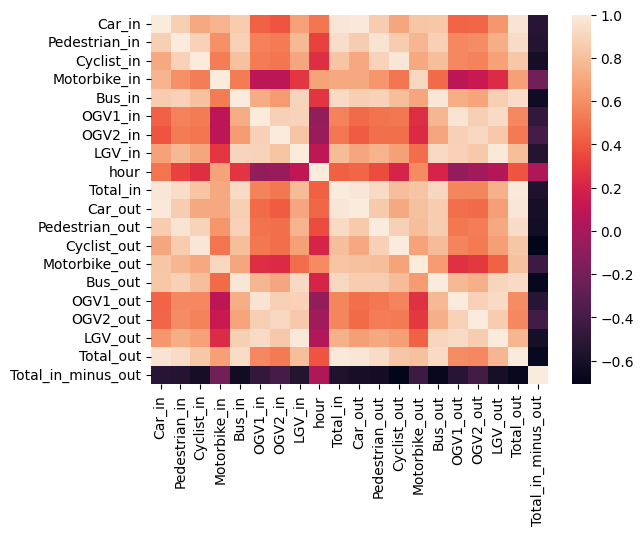

In [40]:
# Plot a correlation heatmap
sns.heatmap(df_sensors_in_out_timegrouped.corr())

Considering we want to model Outflow, lets tabulate the correlations of that variable w.r.t. others

<Axes: >

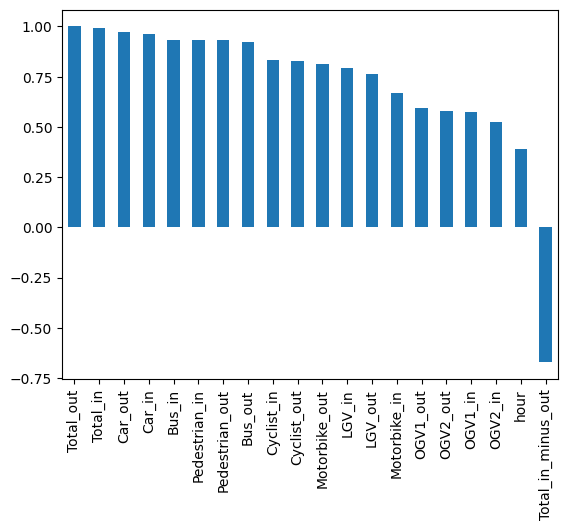

In [41]:
# Correlations for outflow
df_sensors_in_out_timegrouped.corr().loc['Total_out'].sort_values(ascending=False).plot(kind='bar')

<b> Looks like almost all other variables have a moderate or strong correlation to outflow, except 'hour'</b>

<Axes: xlabel='hour', ylabel='Total_out'>

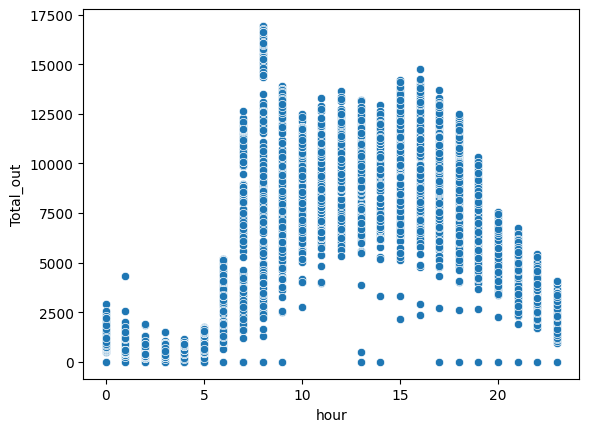

In [42]:
#Explore the relationship of outflow with hour
sns.scatterplot(data=df_sensors_in_out_timegrouped,x='hour',y='Total_out')

This suggests that across all months, the traffic outflow increases from roughly 5 am to 9 am, remains about the same till around 5 pm, then begins to drop after. This could indicate a repeated pattern, or seasonality.

Can we create a strategy to model by hour?

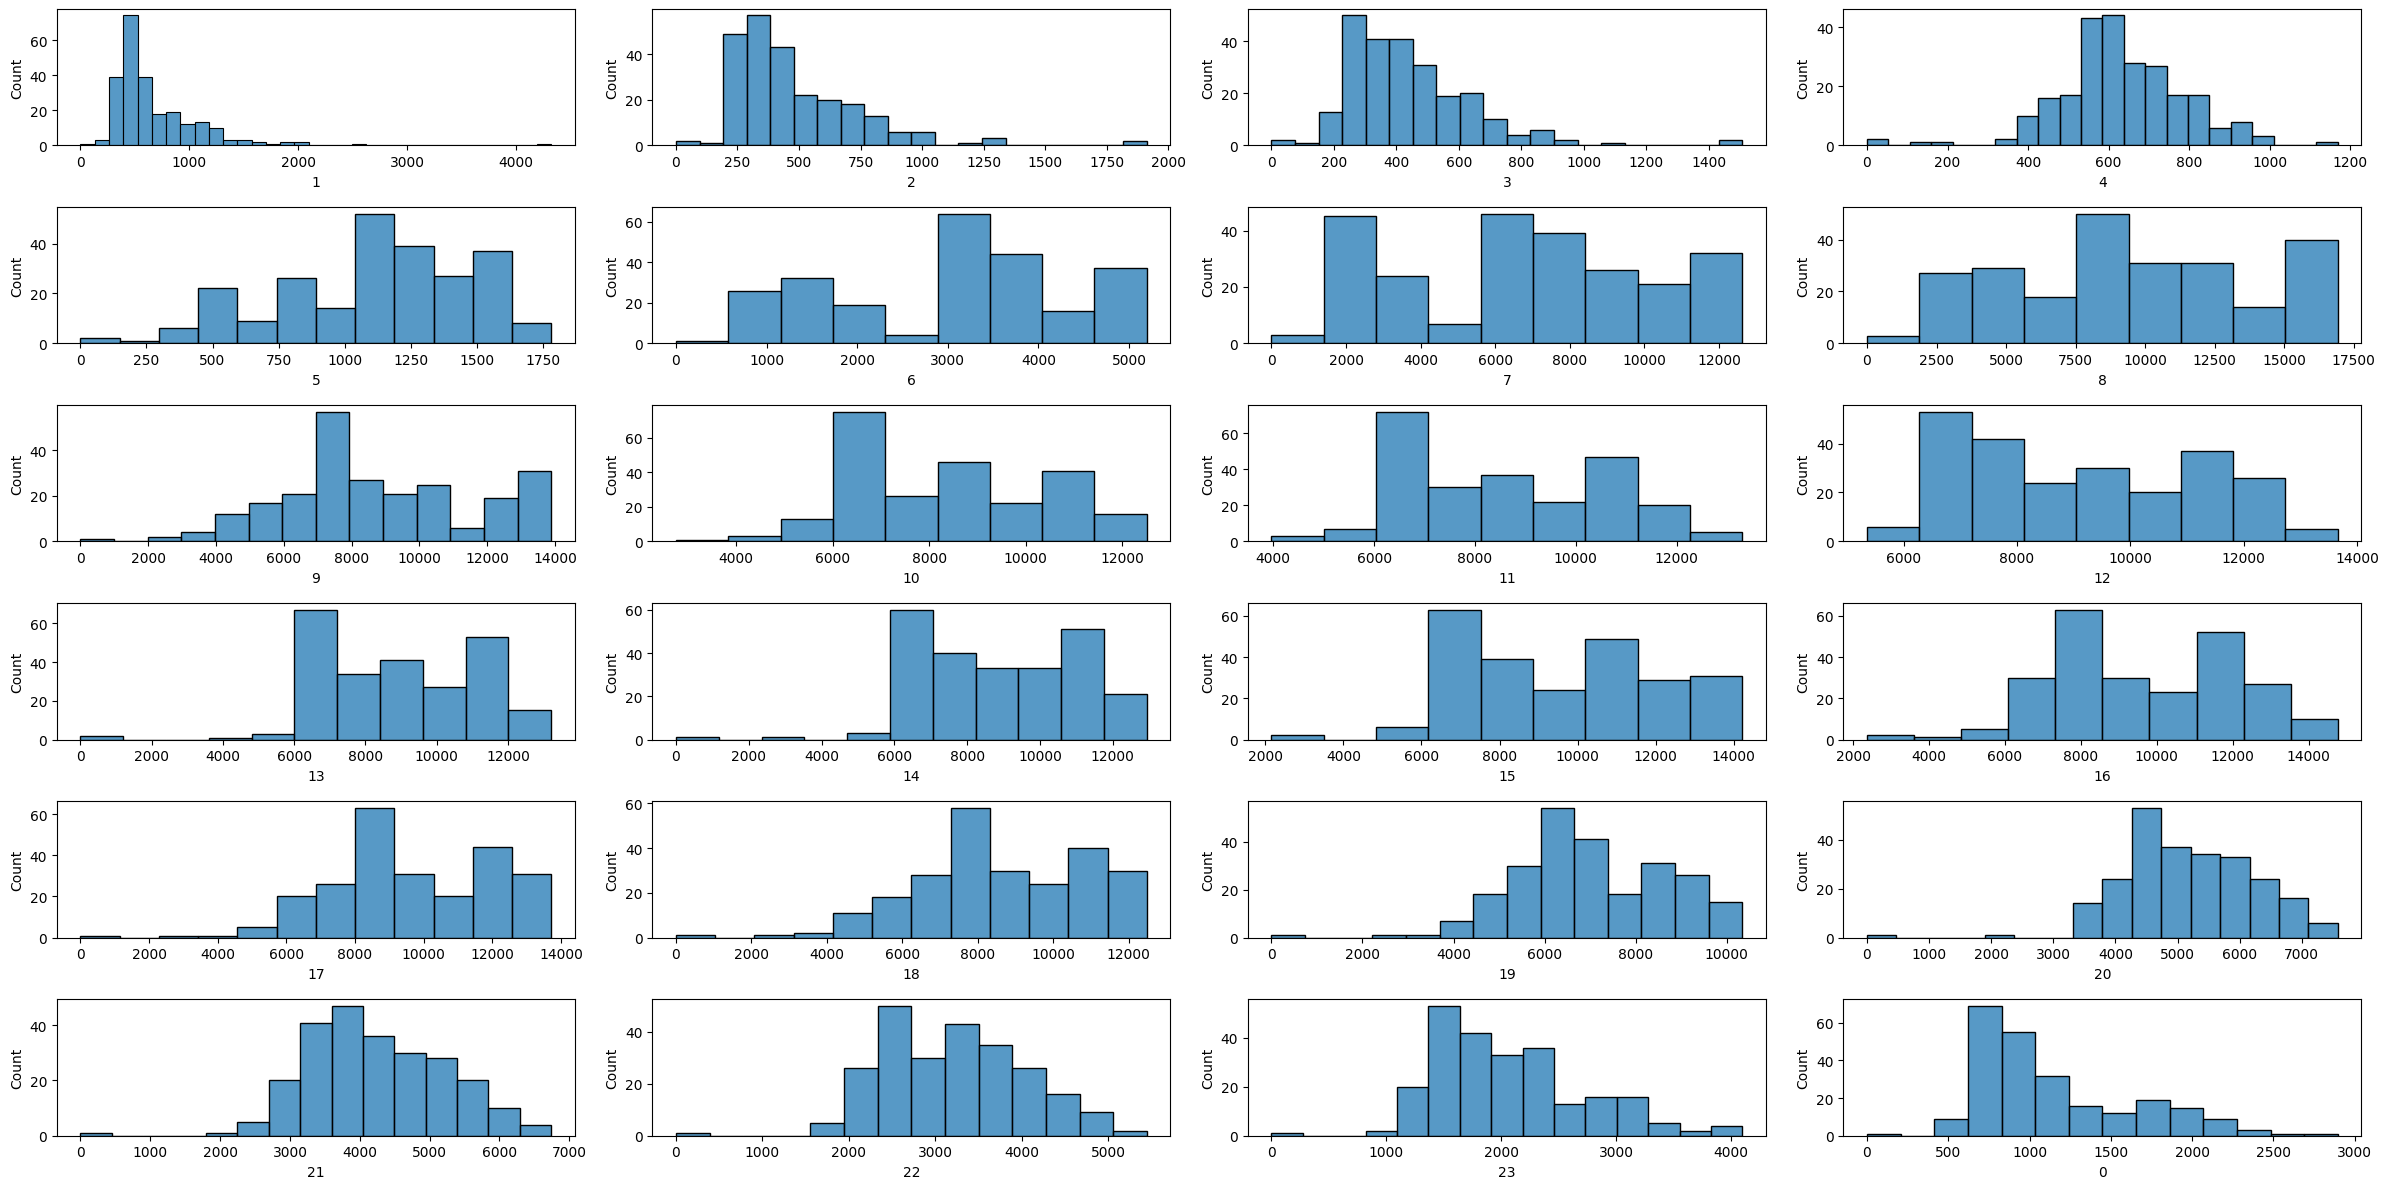

In [43]:
# Plot the distribution of traffic for each hour
df_flow_by_hour = pd.DataFrame()

for hour in df_sensors_in_out['hour'].unique():
    data_for_hour = df_sensors_in_out_timegrouped[df_sensors_in_out_timegrouped['hour'] == hour]['Total_out']
    
    df_flow_by_hour[str(hour)] = data_for_hour.reset_index(drop=True)

Plotsgrid(df_flow_by_hour).histplots()


In [44]:
df_flow_by_hour.describe()

1            2            3            4            5  \
count   243.000000   243.000000   243.000000   243.000000   243.000000   
mean    685.851852   481.251029   439.810700   631.946502  1117.123457   
std     440.280107   262.392660   203.484006   155.777738   362.966214   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     423.000000   297.000000   288.500000   549.000000   880.500000   
50%     527.000000   400.000000   397.000000   627.000000  1173.000000   
75%     841.500000   605.000000   534.000000   720.000000  1380.500000   
max    4322.000000  1913.000000  1507.000000  1169.000000  1782.000000   

                 6             7             8             9            10  \
count   243.000000    243.000000    243.000000    243.000000    243.000000   
mean   3049.917695   6706.316872   9438.946502   8764.345679   8329.098765   
std    1304.119513   3276.953475   4404.725286   2821.395760   2004.073611   
min       0.000000      0.000000      0.000000      0.000000   2753.000000   
25%    1812.500000   3468.000000   5834.000000   7081.000000   6618.000000   
50%    3286.000000   6966.000000   9252.000000   8029.000000   8198.000000   
75%    3856.500000   8764.000000  12638.500000  10413.500000  10093.500000   
max    5195.000000  12627.000000  16932.000000  13892.000000  12504.000000   

       ...            15            16            17            18  \
count  ...    243.000000    243.000000    243.000000    243.000000   
mean   ...   9523.390947   9730.374486   9652.469136   8660.382716   
std    ...   2478.137420   2380.008173   2343.344421   2206.261678   
min    ...   2158.000000   2365.000000      0.000000      0.000000   
25%    ...   7292.500000   7897.500000   8300.500000   7286.500000   
50%    ...   9568.000000   9420.000000   9170.000000   8357.000000   
75%    ...  11502.500000  11869.000000  11885.000000  10743.000000   
max    ...  14216.000000  14766.000000  13717.000000  12480.000000   

                 19           20           21           22           23  \
count    243.000000   243.000000   243.000000   243.000000   243.000000   
mean    7006.436214  5188.366255  4232.629630  3222.386831  2071.769547   
std     1664.245020  1031.345716   984.574743   828.925207   658.233056   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%     5937.000000  4474.500000  3518.000000  2555.000000  1559.500000   
50%     6776.000000  5066.000000  4138.000000  3190.000000  1949.000000   
75%     8408.500000  5993.000000  4970.000000  3794.000000  2418.500000   
max    10345.000000  7579.000000  6742.000000  5446.000000  4098.000000   

                 0  
count   242.000000  
mean   1153.227273  
std     489.331912  
min       0.000000  
25%     775.750000  
50%     980.000000  
75%    1440.500000  
max    2897.000000  

[8 rows x 24 columns]

Non-peak hours have tighter distributions making those hours more reliable for predicting traffic flow

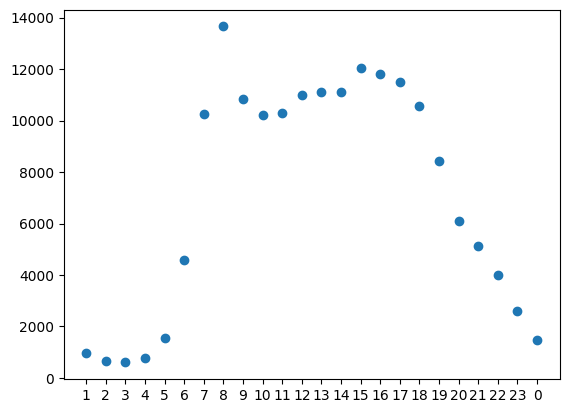

In [45]:
# Plot mean traffic out + 1 std by hour
df_expected_flow_by_hour=df_flow_by_hour.median(axis=0)+df_flow_by_hour.std(axis=0)
plt.plot(df_expected_flow_by_hour,'o')


1
10
17
22


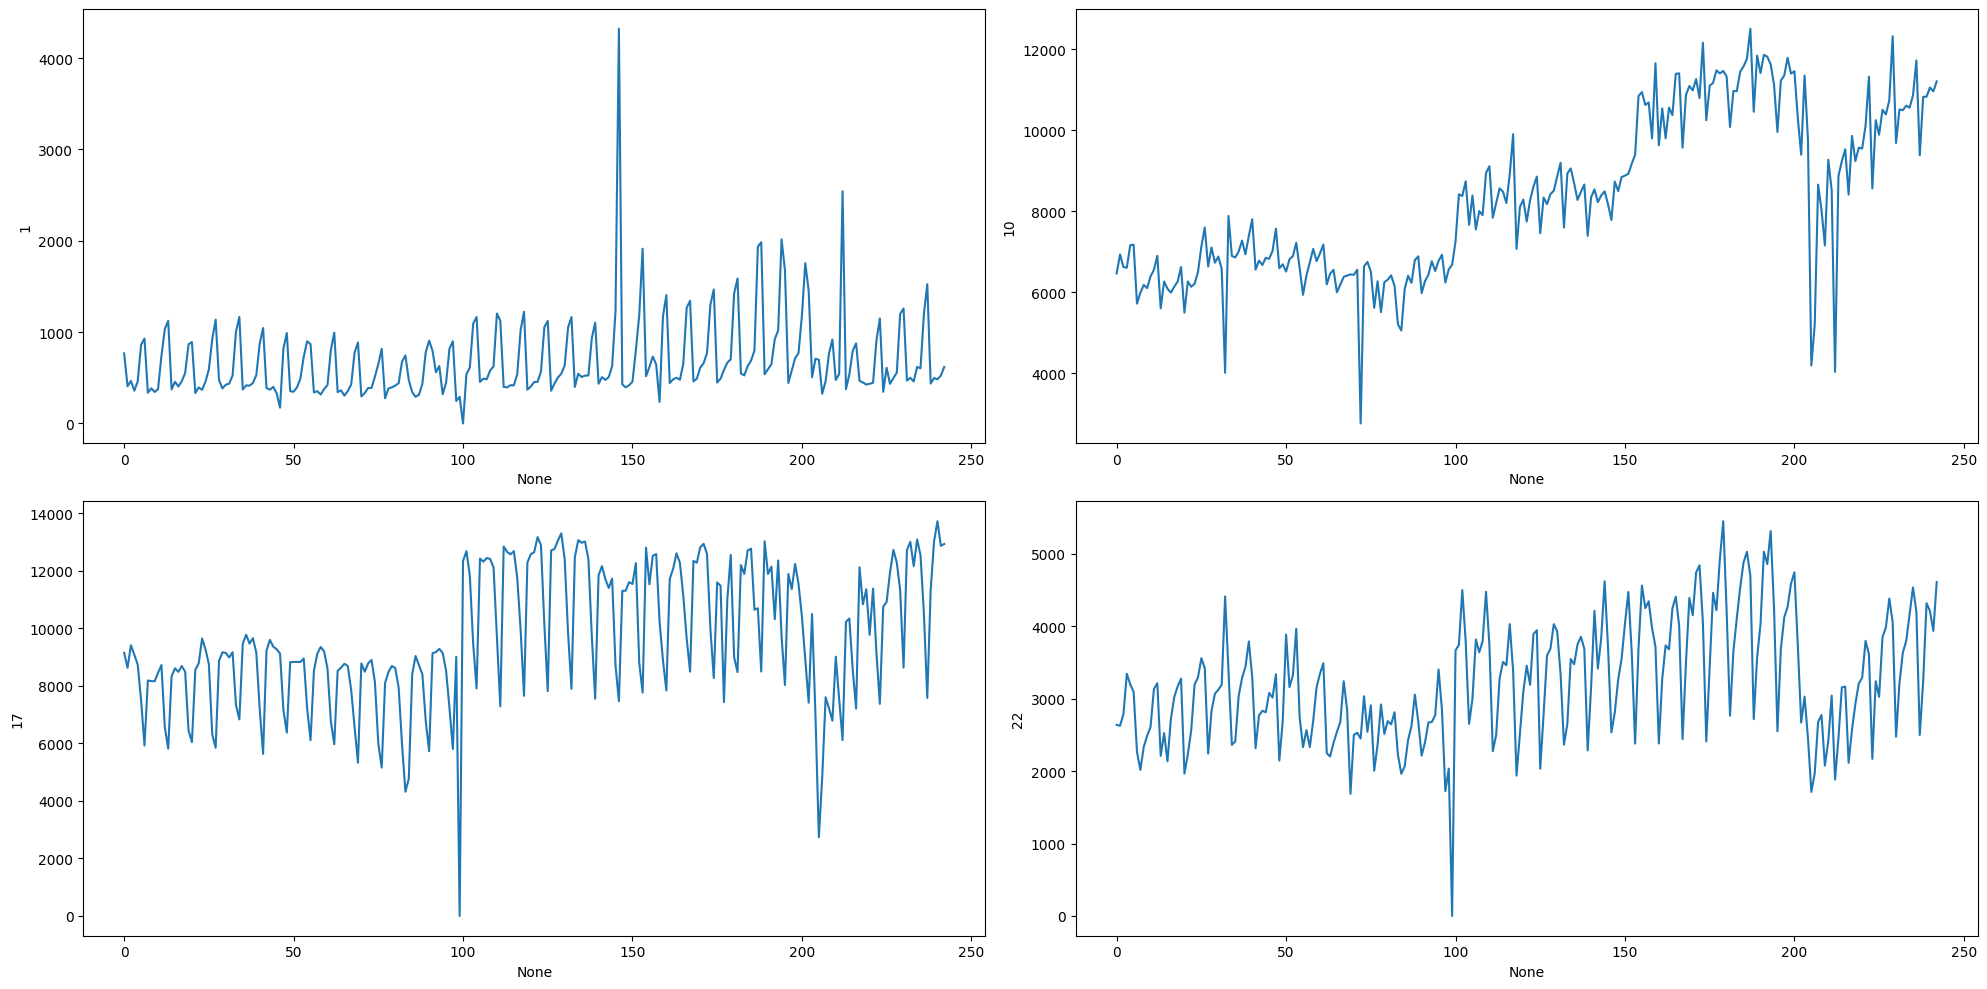

In [46]:
Plotsgrid(df_flow_by_hour[['1','10','17','22']]).lineplots()

In [47]:
# Create a map
expected_flow_by_hour_dict={}
for i,hour in enumerate(df_expected_flow_by_hour.index.tolist()):
    expected_flow_by_hour_dict[float(hour)]=df_expected_flow_by_hour.iloc[i]
print(expected_flow_by_hour_dict)

{1.0: 967.2801074347499, 2.0: 662.3926595743942, 3.0: 600.4840064397722, 4.0: 782.777738261004, 5.0: 1535.9662137151956, 6.0: 4590.119512905843, 7.0: 10242.953474931084, 8.0: 13656.725285898494, 9.0: 10850.395760441459, 10.0: 10202.073611370564, 11.0: 10292.915919288722, 12.0: 11012.672523090187, 13.0: 11107.114276731858, 14.0: 11091.819614194785, 15.0: 12046.137420282013, 16.0: 11800.008173228736, 17.0: 11513.344421232781, 18.0: 10563.261678177045, 19.0: 8440.245020006674, 20.0: 6097.345715624771, 21.0: 5122.574742842017, 22.0: 4018.925206821191, 23.0: 2607.233056439331, 0.0: 1469.331911811413}


In [48]:
# Apply this map to the timegrouped data to create an expected flow column
df_sensors_in_out_timegrouped['Expected Flow']=df_sensors_in_out_timegrouped['hour'].apply(lambda x:expected_flow_by_hour_dict[x])

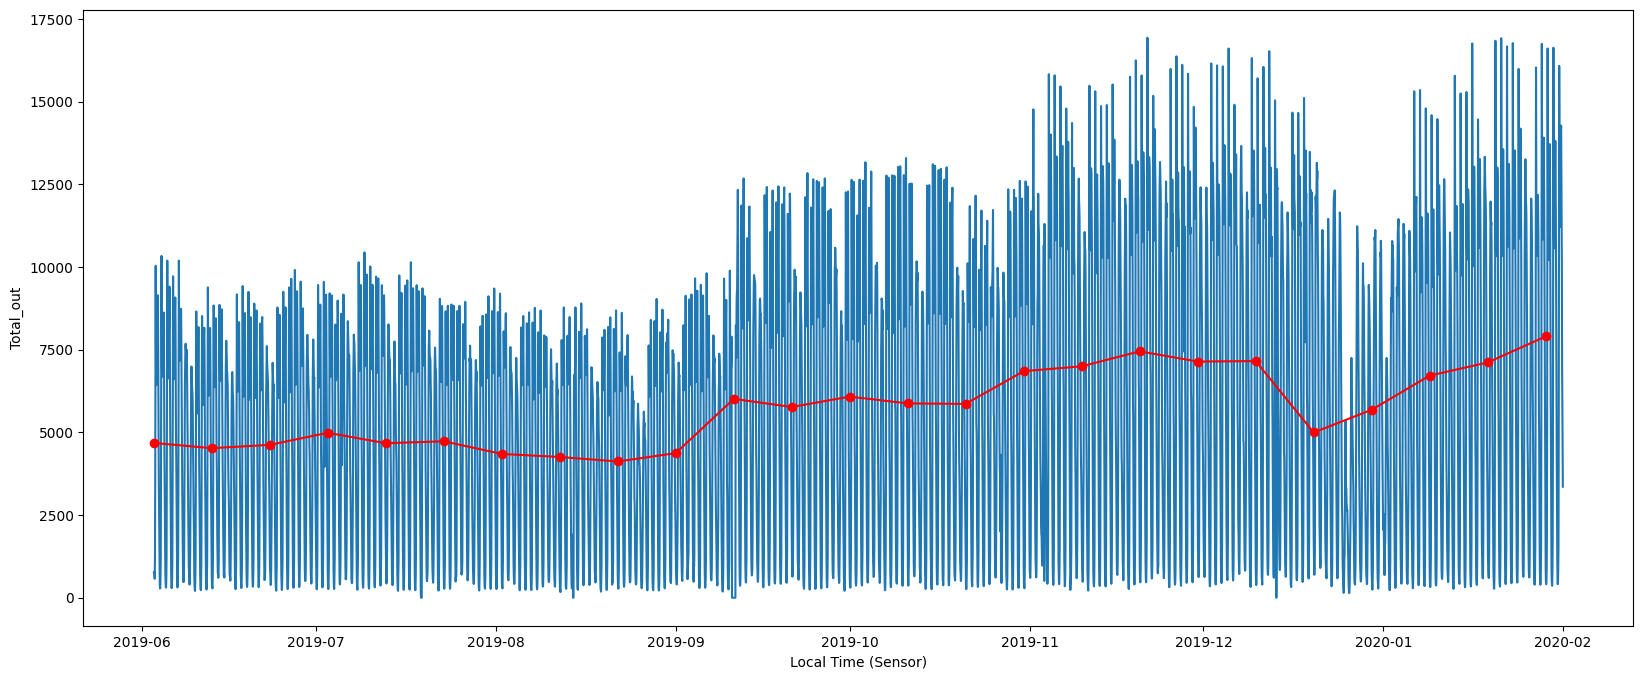

In [49]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df_sensors_in_out_timegrouped,x=df_sensors_in_out_timegrouped.index,y='Total_out')
plt.plot(df_sensors_in_out_timegrouped['Total_out'].resample('10D').mean(),'-or')

<li> We further see that traffic is low during late summer (June to august), starts increasing between september to december and then drops sharply towards the end of december before picking up again. The drop in december might be attributed to the Christmas holiday season 
<li> Based on the limited data we have available, we can conclude that there is a trend, as well as cyclicality

## Modeling

### Data Preparation

Let's explore some scaling options for preparing the data

In [50]:
standardscaler=StandardScaler()
minmaxscaler=MinMaxScaler()
logtransform=FunctionTransformer(np.log1p, validate=True)

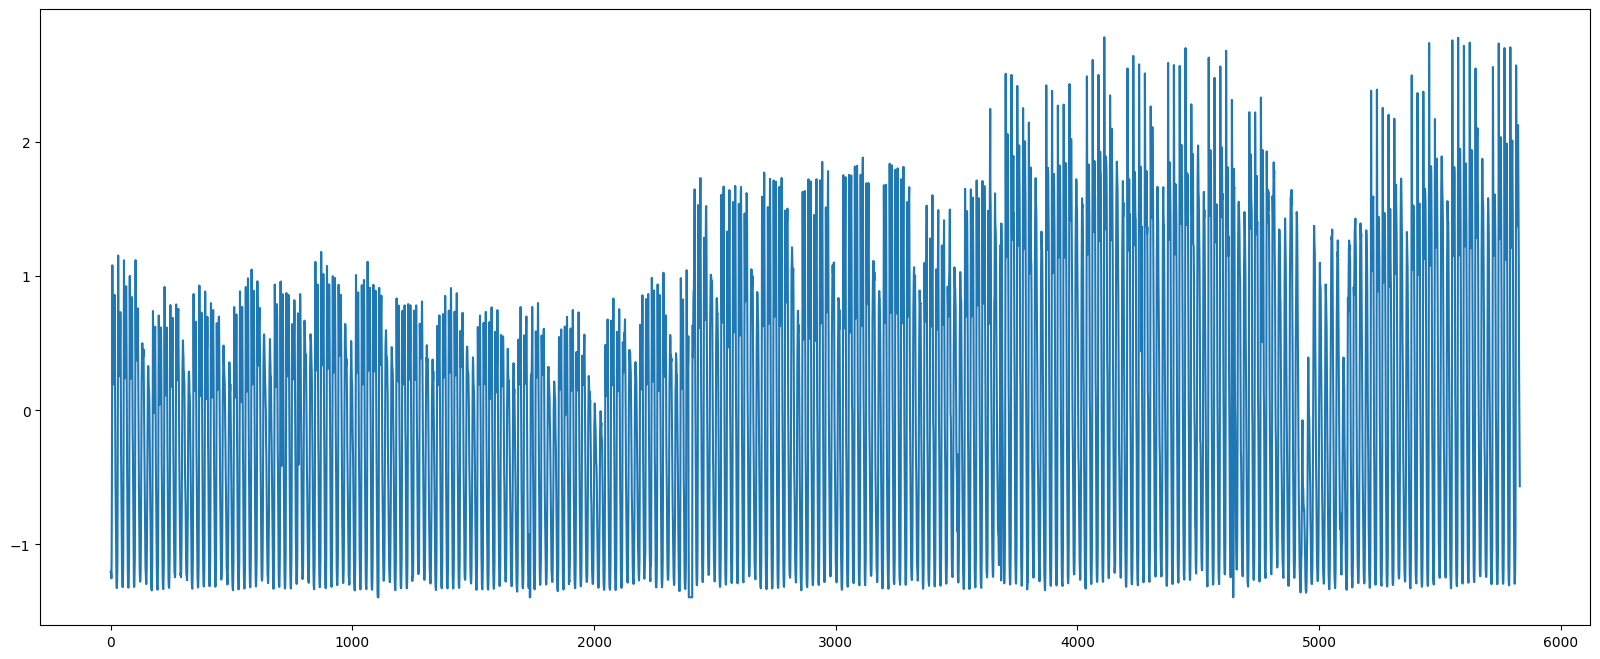

In [51]:
# StandardScaler
plt.figure(figsize=(20,8))
plt.plot(standardscaler.fit_transform(df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)))

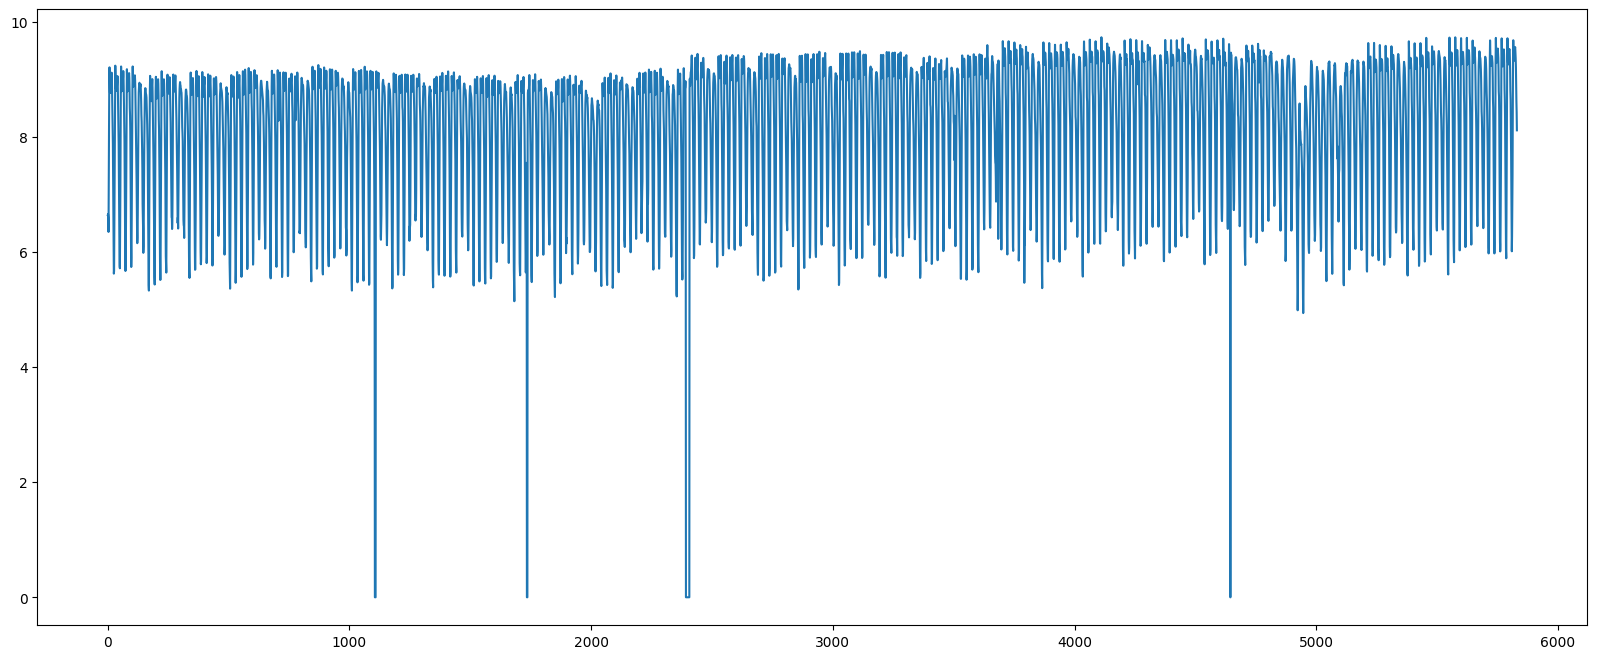

In [52]:
# Log Scaling
plt.figure(figsize=(20,8))
plt.plot(logtransform.fit_transform(df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)))

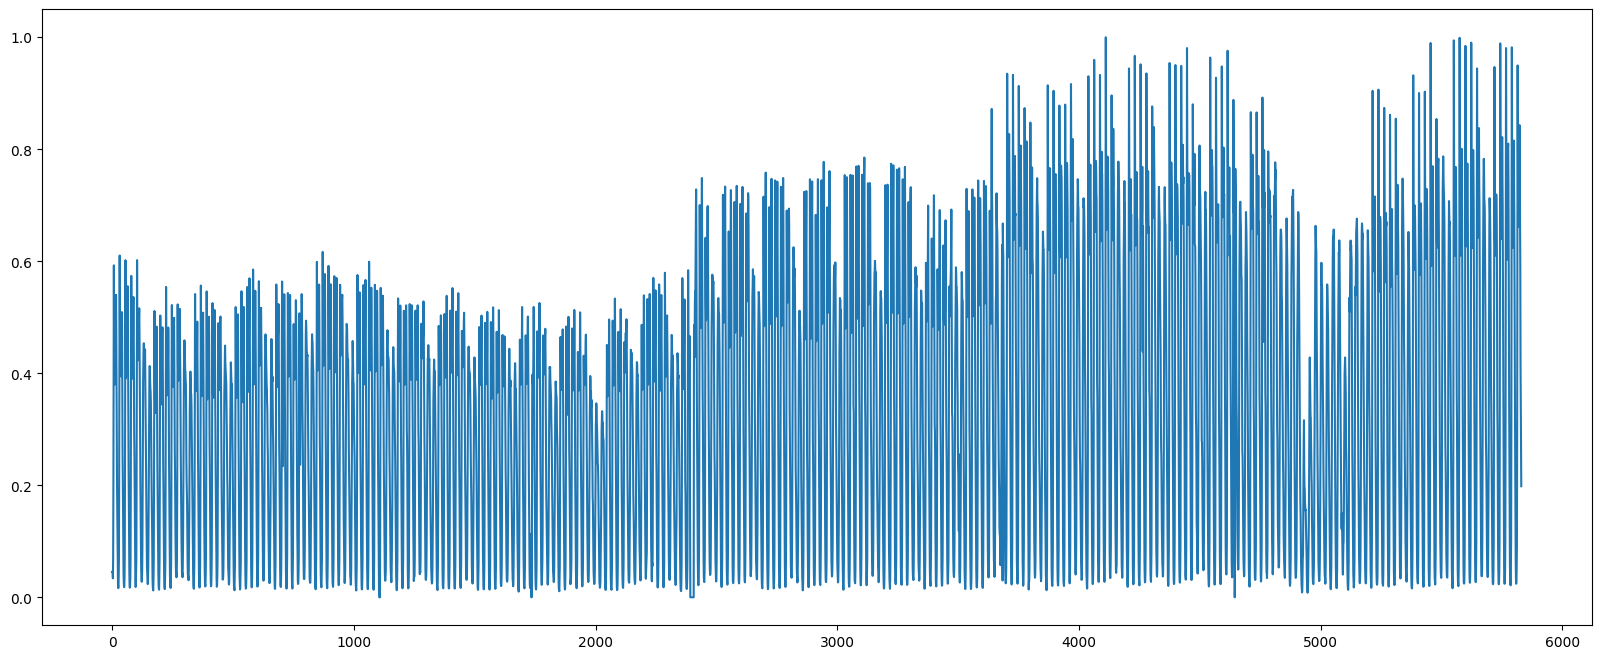

In [53]:
# MinMax Scaer
plt.figure(figsize=(20,8))
plt.plot(minmaxscaler.fit_transform(df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)))

<li> Since we expect the data to have a trend, standard scaler is probably not the best option
<li> Using log scaling drastically improves the order of magnitude but still retains the patterns of the deep valleys. We also don't see an exponential change for which case log transformation may be more appropriate
<li> MinMax scaling gives us data that is not as heavily distributed while retaining most of the original patterns in the data. Hence we can select this scaling method

Prepare data for training and evaluation, and testing (80-20). Since this is time series data, we cannot select random training and testing points because the mode has to learn time varying patterns in the data. So we select the initial 80% for testing and remaining 20% for testing

In [54]:
n=df_sensors_in_out_timegrouped.shape[0]
n_train=int(.8*n)
train_inds=np.arange(n_train+1)
test_inds=np.arange(n_train+1,n)
print(n,n_train,train_inds[-1],test_inds[-1])

5831 4664 4664 5830


### Time Series Forecasting - ARMA based models
<p>
ARMA (Autoregressive Moving Average) is a time series model used for forecasting and analyzing the behavior of time-series data. It is a combination of two components: the Autoregressive (AR) model and the Moving Average (MA) model.

Autoregressive (AR) Model:
The AR model assumes that the current value of a time series can be expressed as a linear function of its past values.
The order of the AR model is denoted as p, which represents the number of past values used to predict the current value.
Moving Average (MA) Model:
The MA model assumes that the current value of a time series can be expressed as a linear function of the current and past error terms (the difference between the actual value and the predicted value).
The order of the MA model is denoted as q, which represents the number of past error terms used to predict the current value.
The ARMA model combines these two components, and the model is denoted as ARMA(p,q), where:

p is the order of the Autoregressive (AR) component
q is the order of the Moving Average (MA) component
<br>The general form of the ARMA(p,q) model is:
<br>
X_t = c + φ_1 * X_(t-1) + φ_2 * X_(t-2) + ... + φ_p * X_(t-p) + 
      ε_t + θ_1 * ε_(t-1) + θ_2 * ε_(t-2) + ... + θ_q * ε_(t-q)
<br>where:
<br>X_t is the observed value of the time series at time t
<br>c is a constant term
<br>φ_1, φ_2, ..., φ_p are the parameters of the AR component
<br>θ_1, θ_2, ..., θ_q are the parameters of the MA component
<br>ε_t is the error term at time t
</p>

In [55]:
X,y=df_sensors_in_out_timegrouped.reset_index().index.values,df_sensors_in_out_timegrouped['Total_out'].values

In [56]:
X_train,X_test,y_train,y_test=X[train_inds],X[test_inds],y[train_inds],y[test_inds]

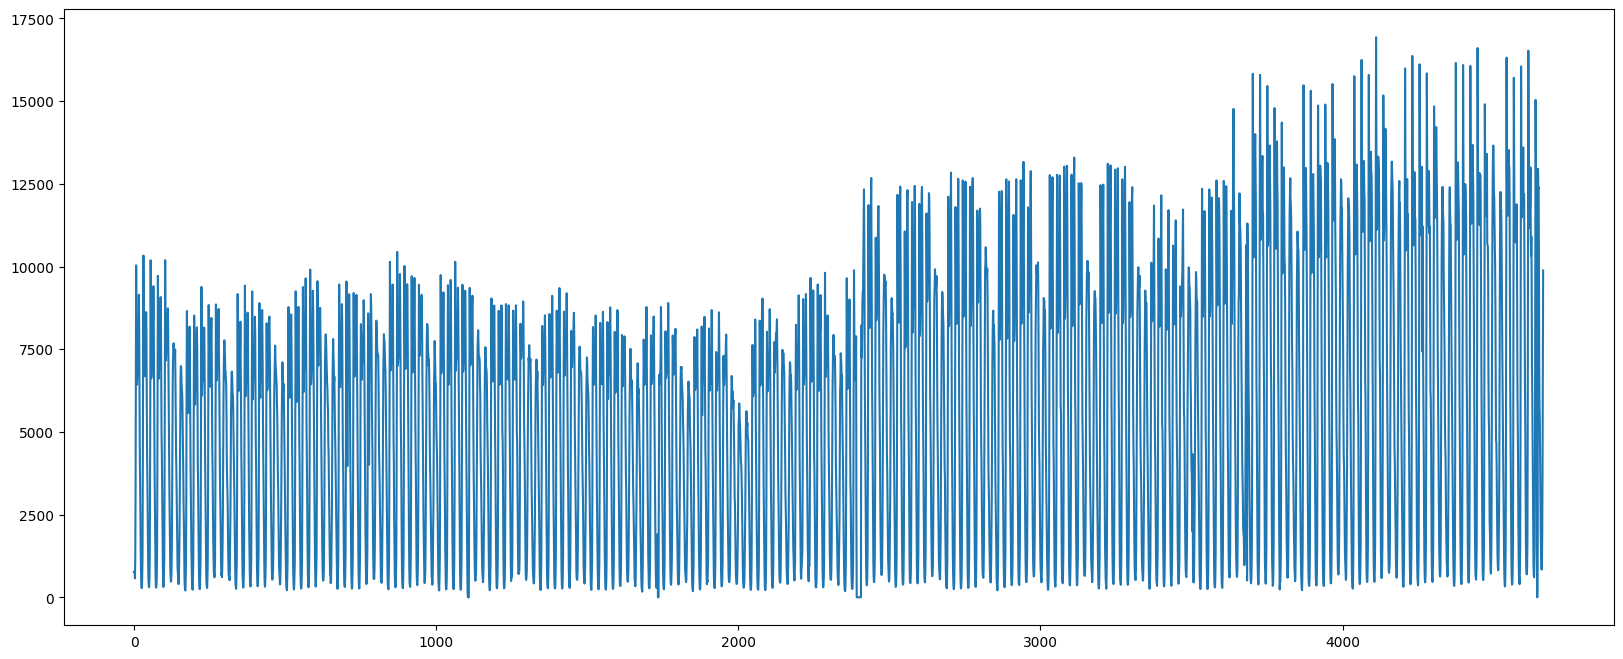

In [57]:
plt.figure(figsize=(20,8))
plt.plot(y_train)

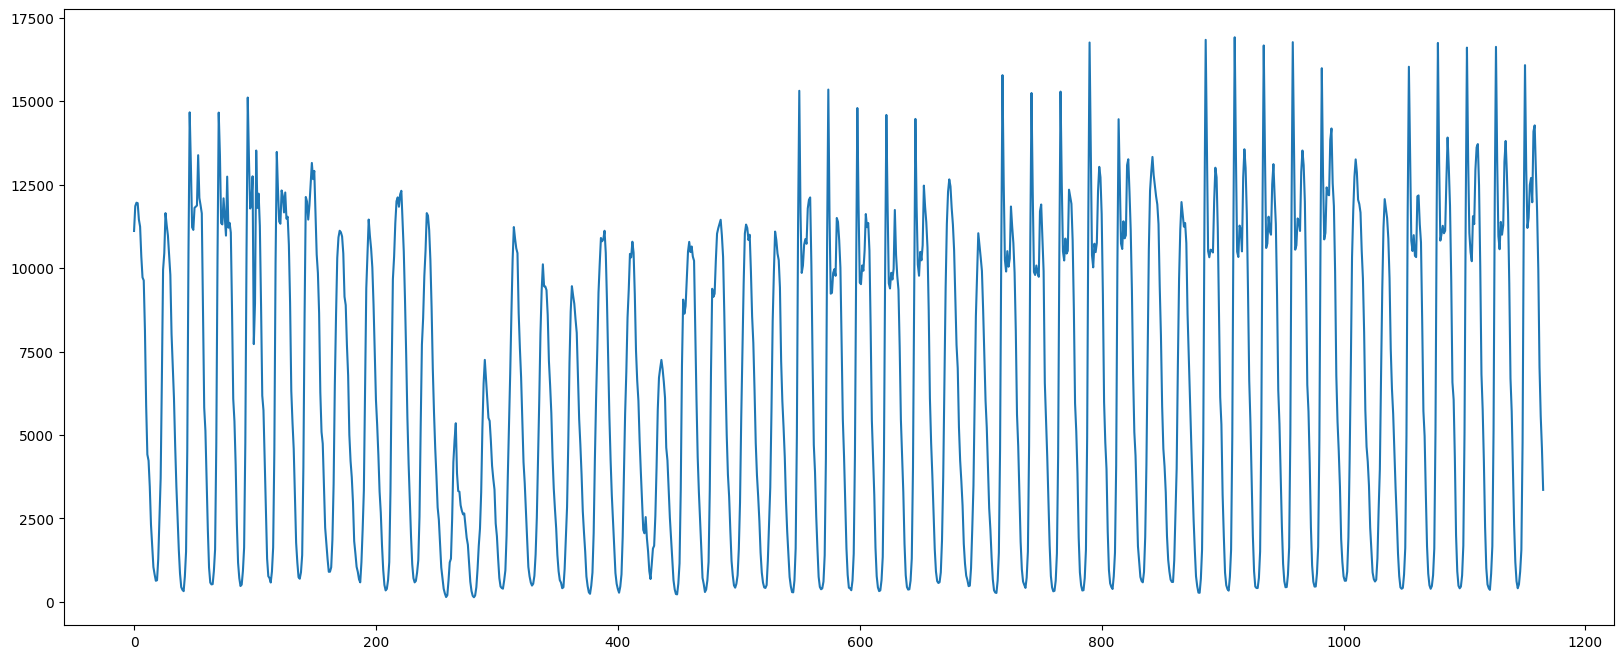

In [58]:
plt.figure(figsize=(20,8))
plt.plot(y_test)

Two important questions are: <br>
<li> How many terms to include for AR
<li> How many terms to include for MA <br>
<br> To get these answers we start by plotting the correlations of lagged data to the original data, also called autocorrelation

Let's take the lag(1) values 

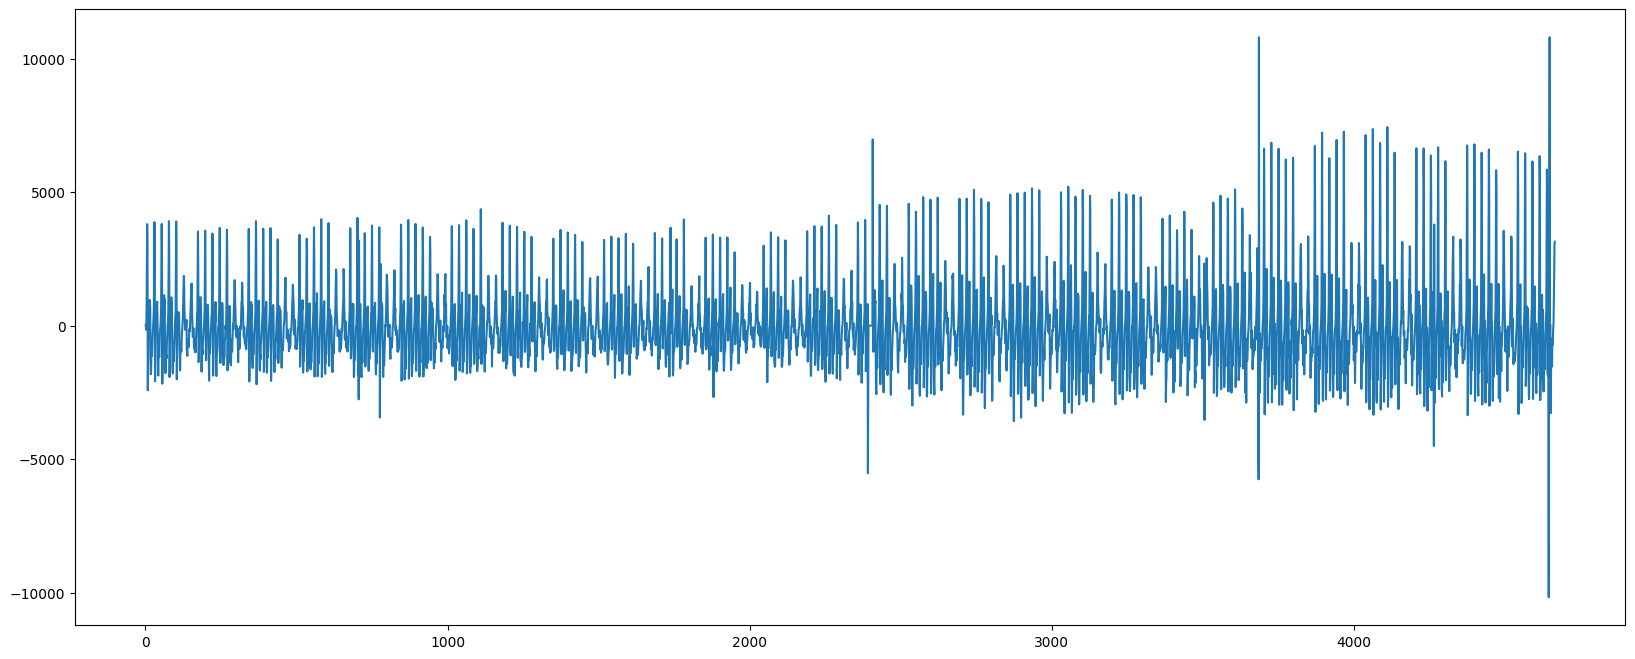

In [59]:
y_train_diff=pd.DataFrame(y_train).diff().dropna()
plt.figure(figsize=(20,8))
plt.plot(y_train_diff)

We see significant trends.

<b> Obtaining MA value 

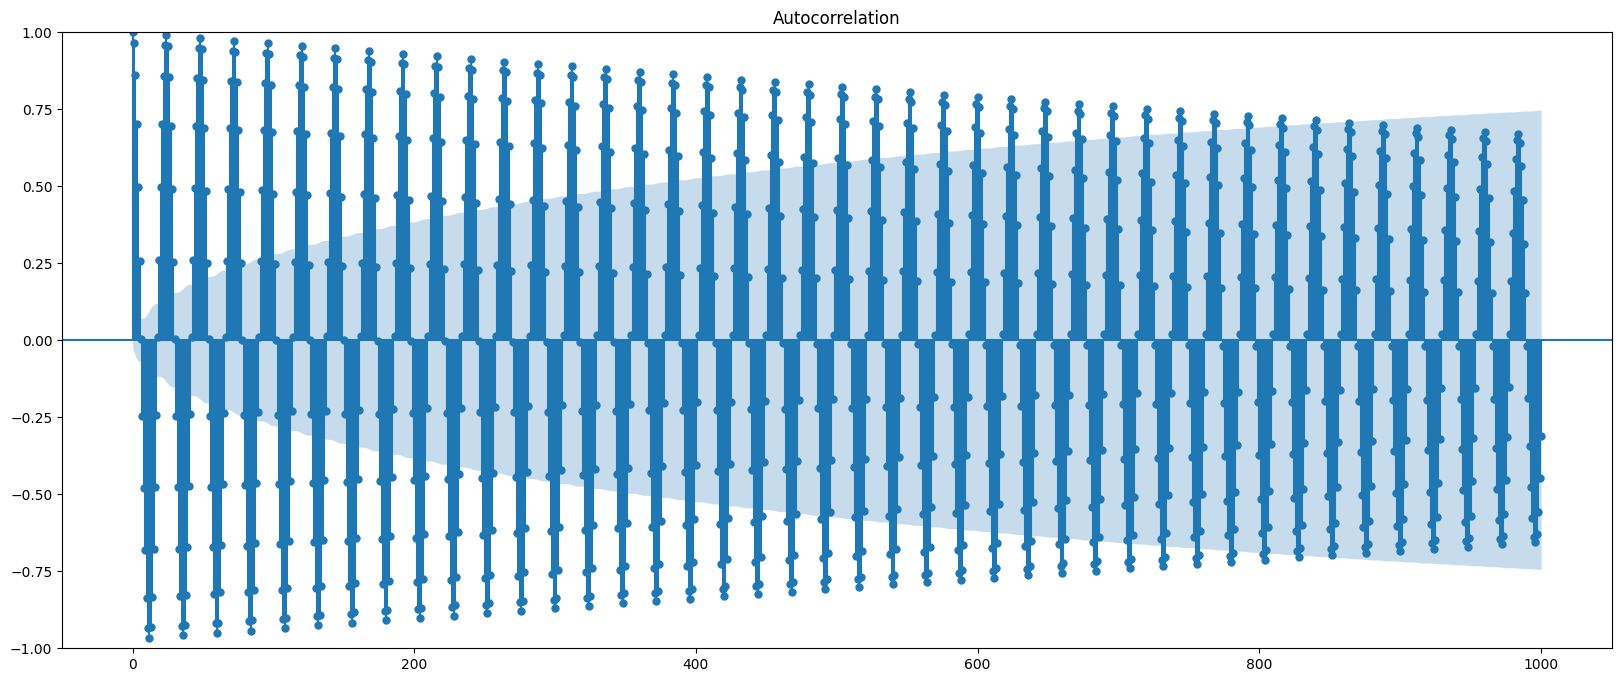

In [60]:
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
n_obs=y_train.shape[0]
n_lags=n_obs 
lag_acf=acf(y_train,nlags=n_lags)
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the autocorrelation function with 95% confidence intervals and 1000 lags
plot_acf(lag_acf, alpha=0.05, lags=1000, ax=ax)

plt.show()

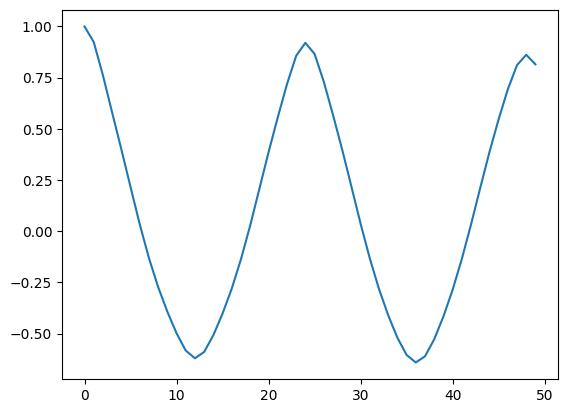

In [61]:
plt.plot(lag_acf[:50])

Adjusting for seasonality by taking the lagged difference and determining the auto-correlation

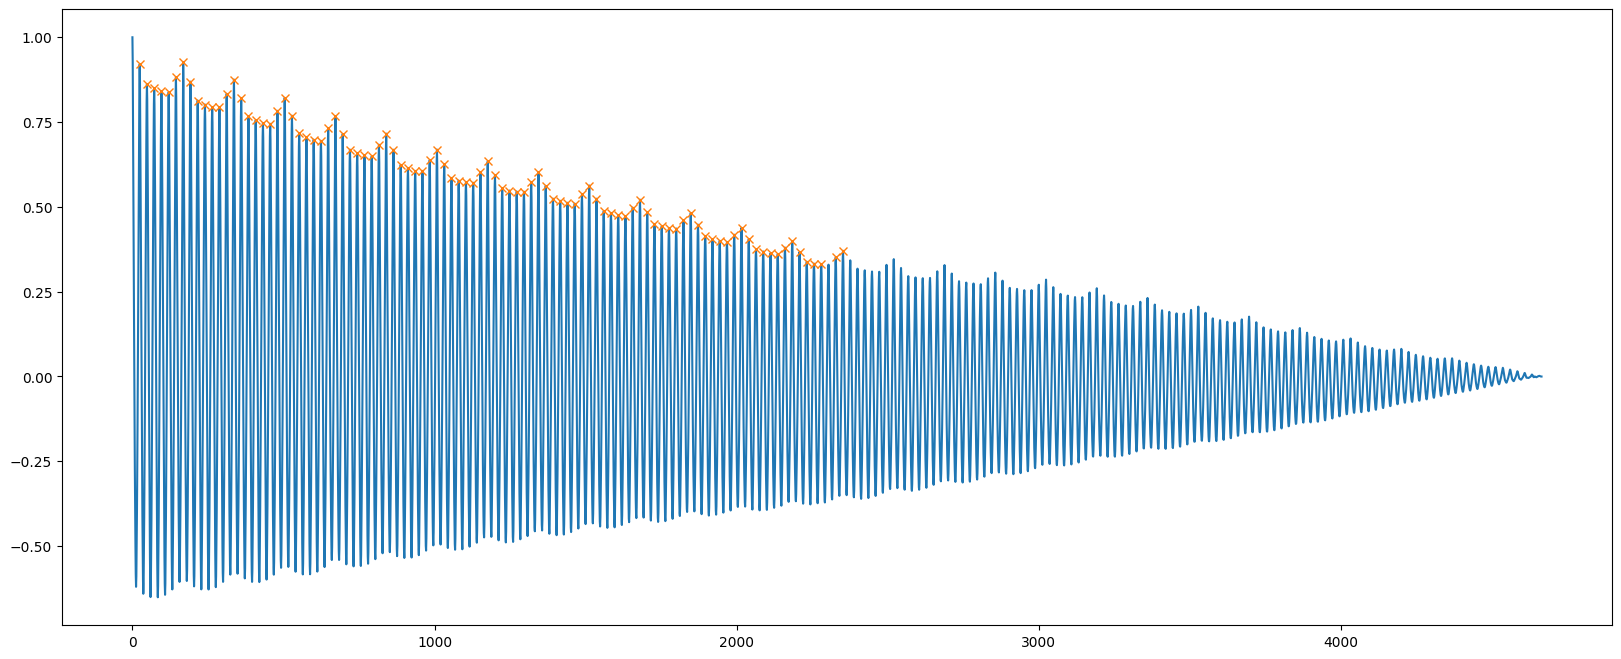

In [62]:
# Calculate the seasonality by determining the peaks of the ACF plots
peaks1, _ = scipy.signal.find_peaks(lag_acf,prominence=.7)
plt.figure(figsize=(20,8))
plt.plot(lag_acf)
plt.plot(peaks1,lag_acf[peaks1],'x')


In [63]:
# Plotting the autocorrelation of the 2nd peaks difference
y_train_sa=pd.DataFrame(y_train).diff(peaks1[0]).dropna().values.flatten()
y_train_sa

array([ -359.,  -504.,  -446., ..., -6447., -8297., -3614.])

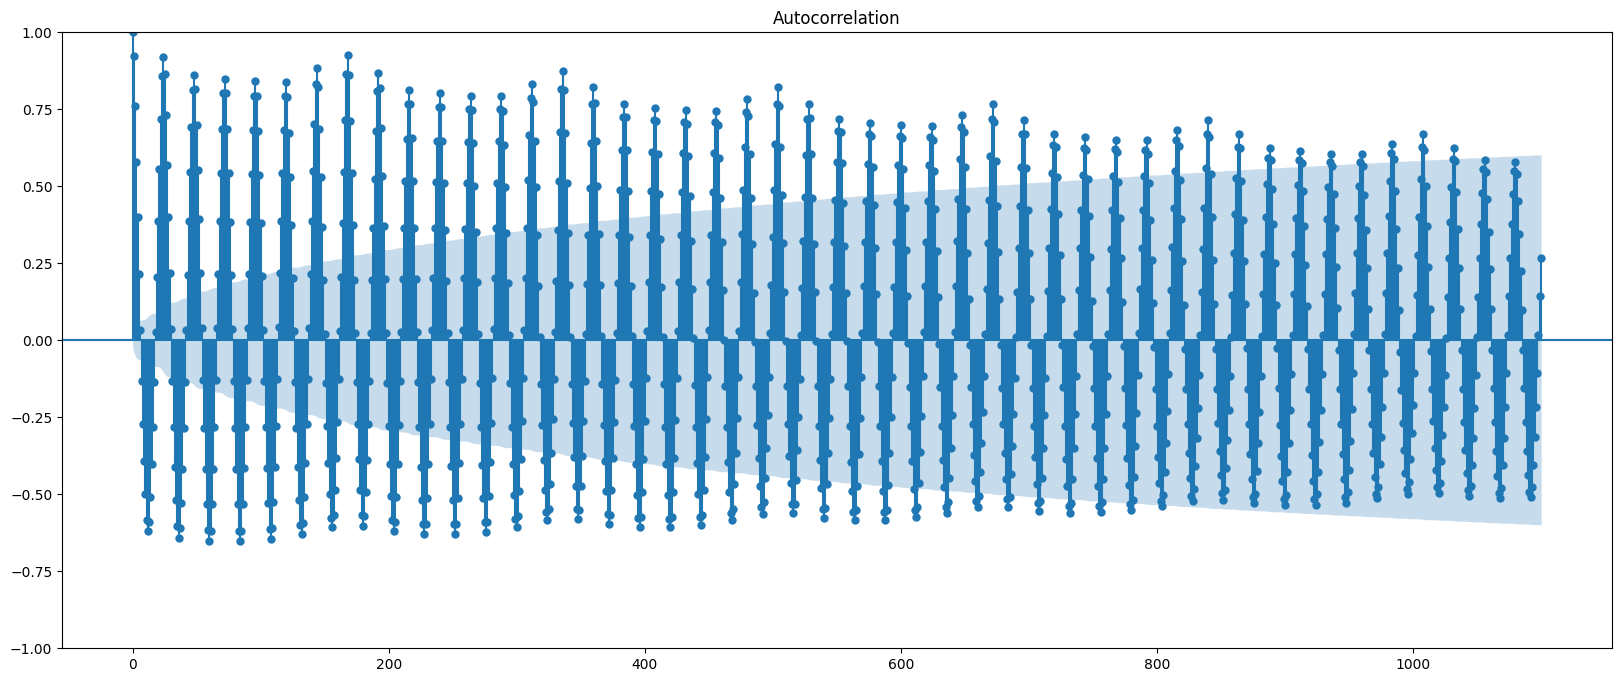

In [64]:

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the autocorrelation function with 95% confidence intervals and 1000 lags
plot_acf(y_train, alpha=0.05, lags=1100, ax=ax)

plt.show()

We see a seasonal effect even in the peaks and the differenced signal won't be stationary. Let's take the peaks of these peaks to get a better measure of true seasonality

[ 168  336  504  672  840 1008 1176 1344 1512 1680 1848 2016 2184]


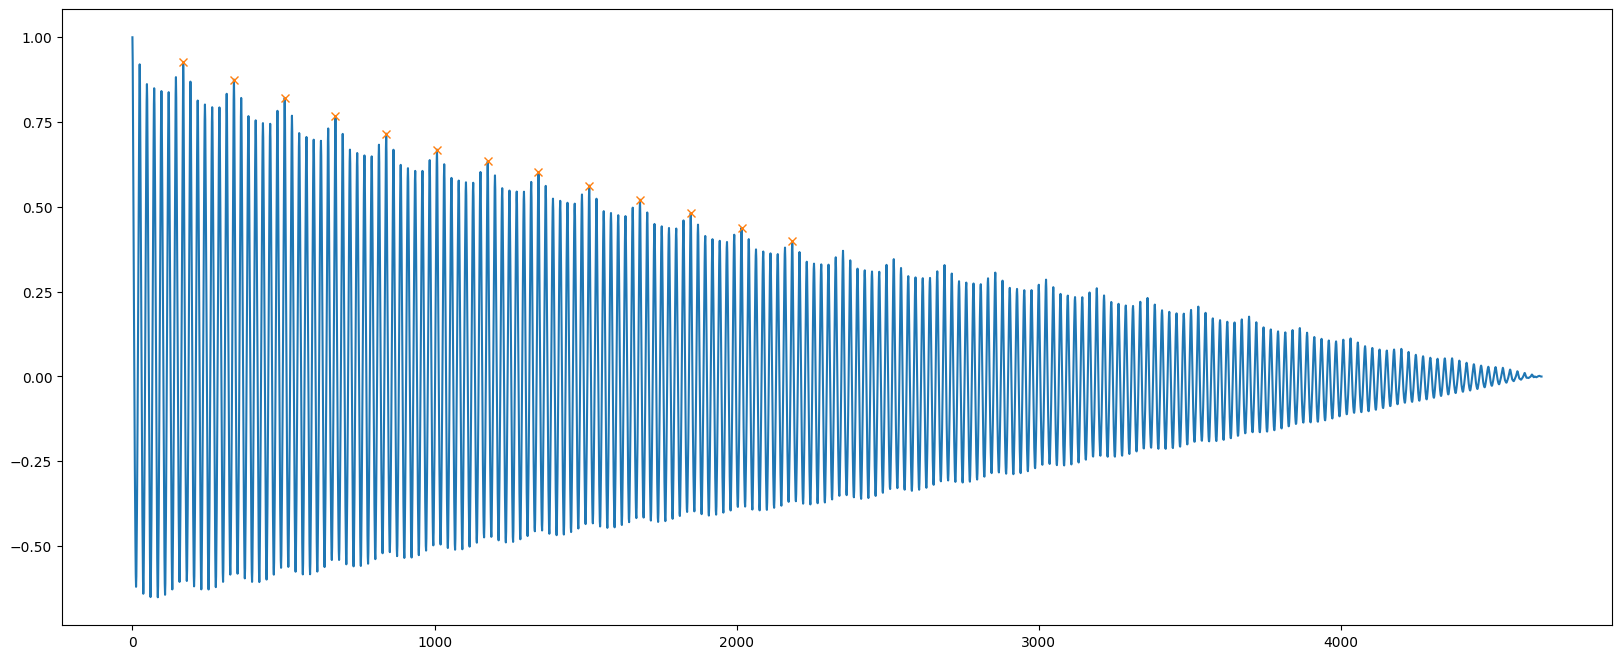

In [65]:
######################### Second Peak ###############
peaks2,_=scipy.signal.find_peaks(lag_acf[peaks1])
plt.figure(figsize=(20,8))
plt.plot(lag_acf)
plt.plot(peaks1[peaks2],lag_acf[peaks1[peaks2]],'x')
print(peaks1[peaks2])

Taking the lagged difference of this peaks distance should hopefully help us reduce the effect of seasonality

In [66]:
# Plotting the autocorrelation of the 2nd peaks difference
y_train_sa=pd.DataFrame(y_train).diff(peaks1[peaks2][0]).dropna().values.flatten()
y_train_sa

array([ -430.,  -555.,  -530., ...,  -858., -1425., -1148.])

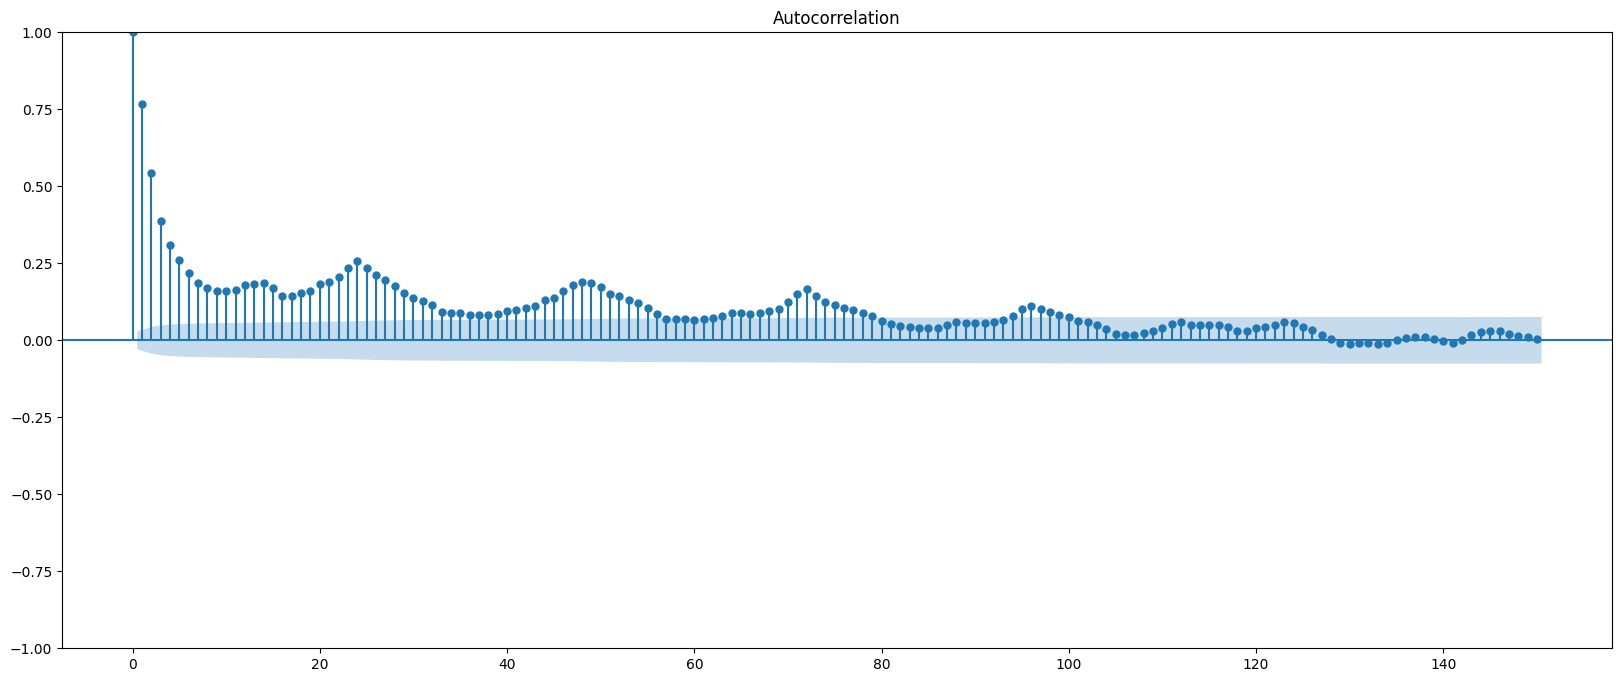

In [67]:

# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the autocorrelation function with 95% confidence intervals and 1000 lags
plot_acf(y_train_sa, alpha=0.05, lags=150, ax=ax)

plt.show()

Although not perfect, the 2nd peak difference helps us greatly reduce the seasonal effect

In [68]:
#Second difference
diff=peaks1[peaks2][0]
print(diff)

168


In [69]:
# Let's perform an Augmented Dickey-Fuller (ADF) test to determine stationarity
from statsmodels.tsa.stattools import adfuller

# Example time series data (replace with your own)
data = y_train_sa

# Perform the ADF test
result = adfuller(data)

# Output the test results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

if result[1] < 0.05:
    print("Reject the null hypothesis - The series is stationary")
else:
    print("Fail to reject the null hypothesis - The series is non-stationary")


ADF Statistic: -7.2468997981949475
p-value: 1.822272981361068e-10
Critical Values: {'1%': -3.4318134440597237, '5%': -2.8621866671873724, '10%': -2.567114224618895}
Reject the null hypothesis - The series is stationary


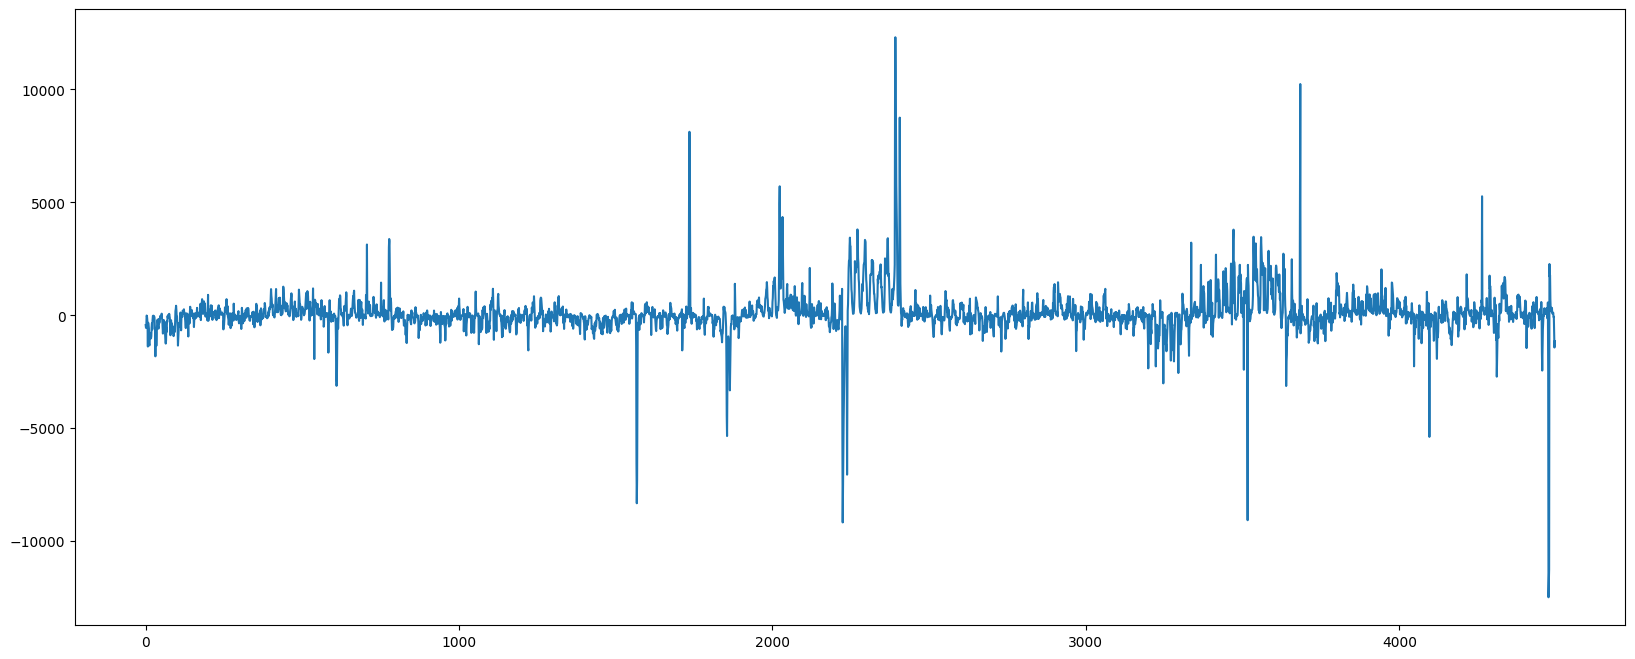

In [70]:
plt.figure(figsize=(20,8))
plt.plot(y_train_sa)

Hence our 'q' value in the ARMA model (or MA value) = 168

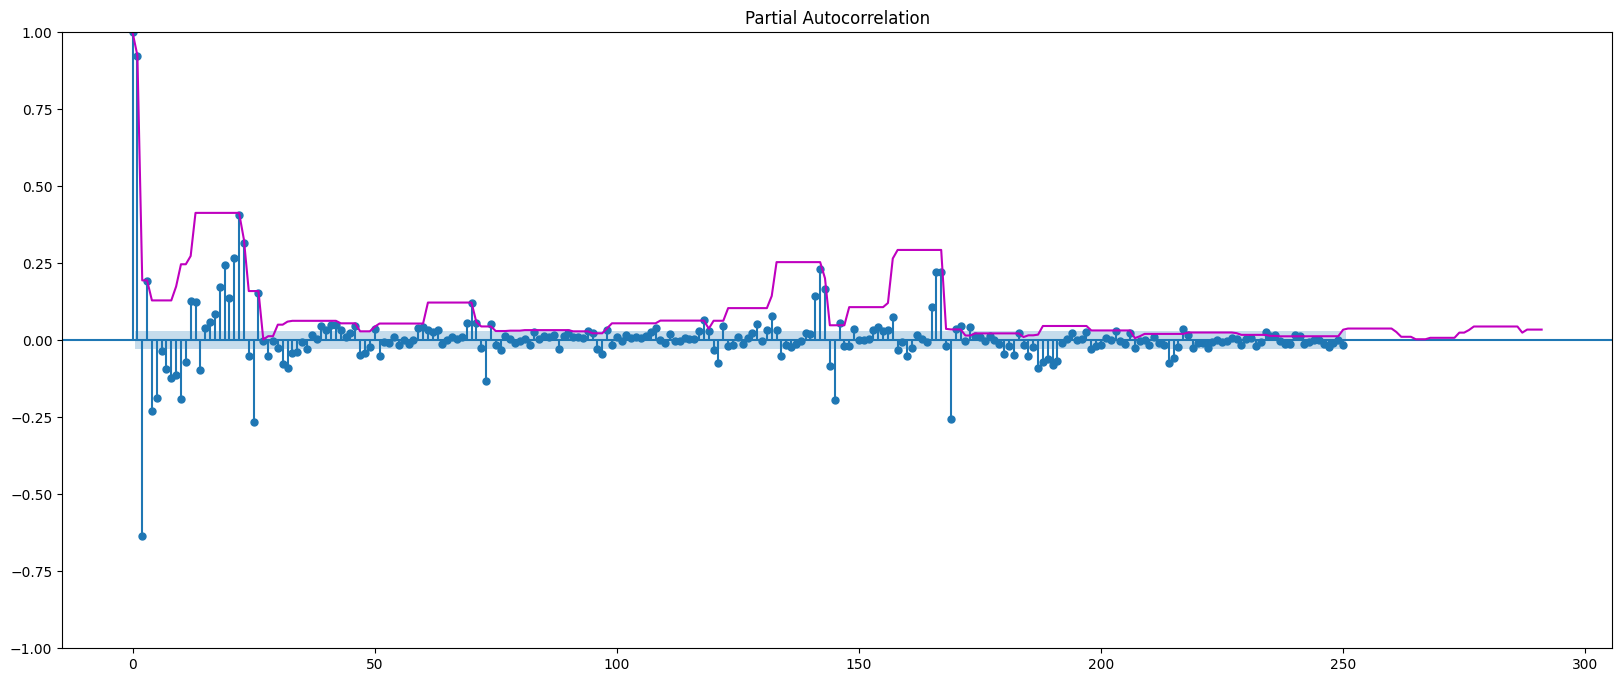

In [71]:

# Find the number of observations by taking the length of the returns DataFrame
nobs = y_train_diff.shape[0]
nlags=int(nobs/2)

# Calculate the ACF
lag_pacf = pacf(y_train, nlags=300)
# Moving maximum lag pacf
lag_pacf_moving=np.abs(pd.DataFrame(lag_pacf).rolling(10).max().dropna().values)
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the autocorrelation function with 95% confidence intervals and 1000 lags
plot_pacf(y_train, alpha=0.05, lags=250, ax=ax)

# Plot the moving PACF
plt.plot(lag_pacf_moving,'-m')

plt.show()

In [72]:

print(np.argwhere(np.abs(lag_pacf_moving)<1.96/(np.sqrt(nlags)))[:5])

[[27  0]
 [28  0]
 [29  0]
 [47  0]
 [48  0]]


<li> The uncertainty remains consistent over time, so we can determine the AR coefficient from this PACF plot
<li> The rolling maximum comes close to the confidence bounds at around index 27, hence we can take this value to be the AR value (p)

Model without differencing

In [73]:
# Import the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Example time series data
data = y_train
# Convert to a pandas Series
series = pd.Series(data)

In [74]:
# Specify ARIMA parameters
p,d,q=27,0,5
# Fit ARIMA model
model = ARIMA(series, order=(p,d,q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=len(test_inds))
print(forecast)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4665
Model:                ARIMA(27, 0, 5)   Log Likelihood              -37426.666
Date:                Sat, 24 Aug 2024   AIC                          74921.332
Time:                        22:45:41   BIC                          75140.558
Sample:                             0   HQIC                         74998.438
                               - 4665                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5475.2577    467.353     11.715      0.000    4559.263    6391.252
ar.L1          0.5526     19.627      0.028      0.978     -37.916      39.021
ar.L2         -0.0480     16.514     -0.003      0.9

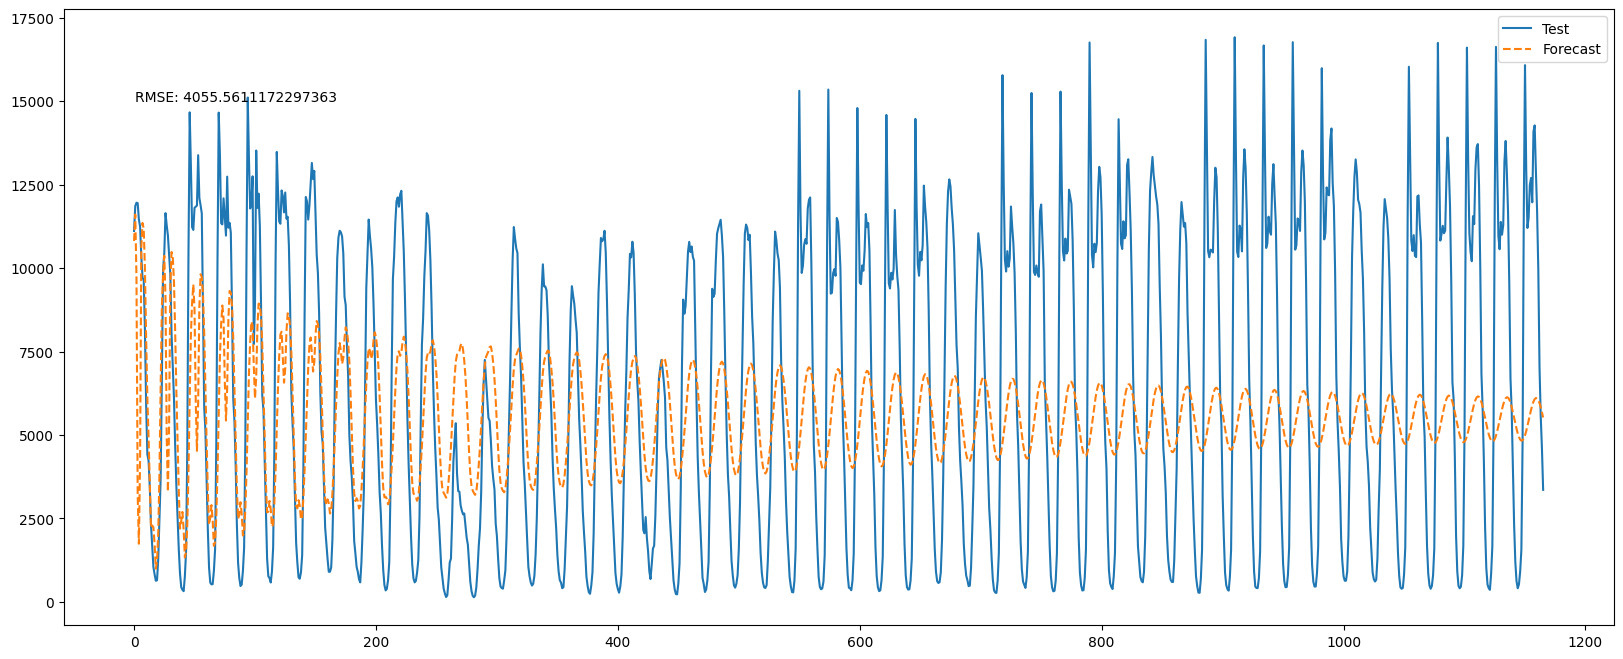

In [75]:
# Calculate the accuracy (RMSE)
mse_model=mean_squared_error(y_test,forecast)
rmse_model=mse_model**.5
# Plot the original data and forecast
plt.figure(figsize=(20,8))
#plt.plot(series, label='Original Data')
#plt.plot(range(len(series), len(series) + len(test_inds)), forecast, label='Forecast')
plt.plot(range(len(test_inds)),y_test,label='Test')
plt.plot(range(len(test_inds)),forecast,'--',label='Forecast')
plt.text(.5,15000,f'RMSE: {rmse_model}')
plt.legend()
plt.show()

In [76]:
# Try a different combination
p,d,q=27,0,50
# Fit ARIMA model
model = ARIMA(series, order=(p,d,q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=len(test_inds))
print(forecast)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4665
Model:               ARIMA(27, 0, 50)   Log Likelihood              -37272.875
Date:                Sat, 24 Aug 2024   AIC                          74703.750
Time:                        22:59:25   BIC                          75213.129
Sample:                             0   HQIC                         74882.908
                               - 4665                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5475.2577    385.929     14.187      0.000    4718.852    6231.664
ar.L1          0.0926      0.727      0.127      0.899      -1.333       1.518
ar.L2         -0.1022      0.719     -0.142      0.8

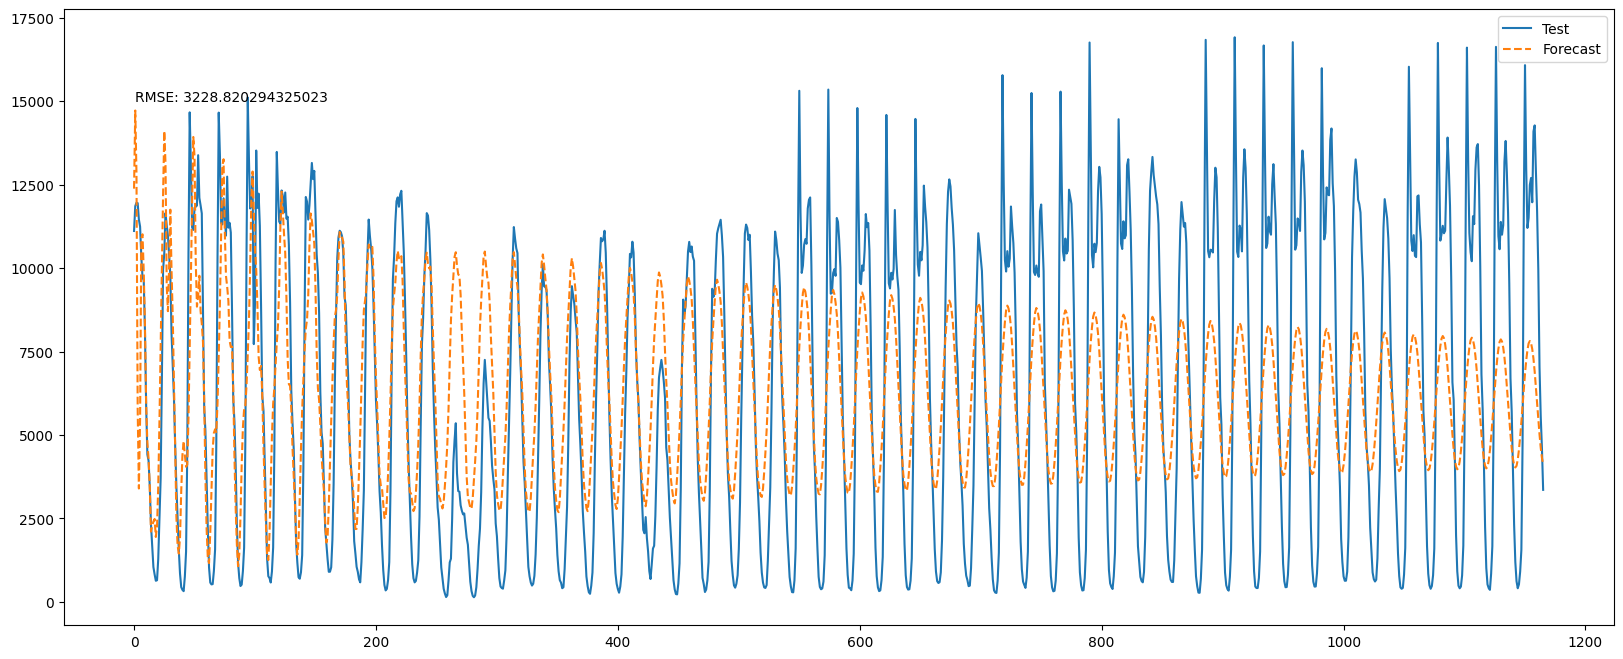

In [77]:
# Calculate the accuracy (RMSE)
mse_model=mean_squared_error(y_test,forecast)
rmse_model=mse_model**.5
# Plot the original data and forecast
plt.figure(figsize=(20,8))
#plt.plot(series, label='Original Data')
#plt.plot(range(len(series), len(series) + len(test_inds)), forecast, label='Forecast')
plt.plot(range(len(test_inds)),y_test,label='Test')
plt.plot(range(len(test_inds)),forecast,'--',label='Forecast')
plt.text(.5,15000,f'RMSE: {rmse_model}')
plt.legend()
plt.show()

We see a significant change in accuracy between q=5 and q=30. Increasing q might provide much better accuracy but it becomes too computationally expensive. 

In [78]:
# Create an expected flow array for the test data based on hours
expected_flow_test=df_sensors_in_out_timegrouped['Expected Flow'].iloc[test_inds]

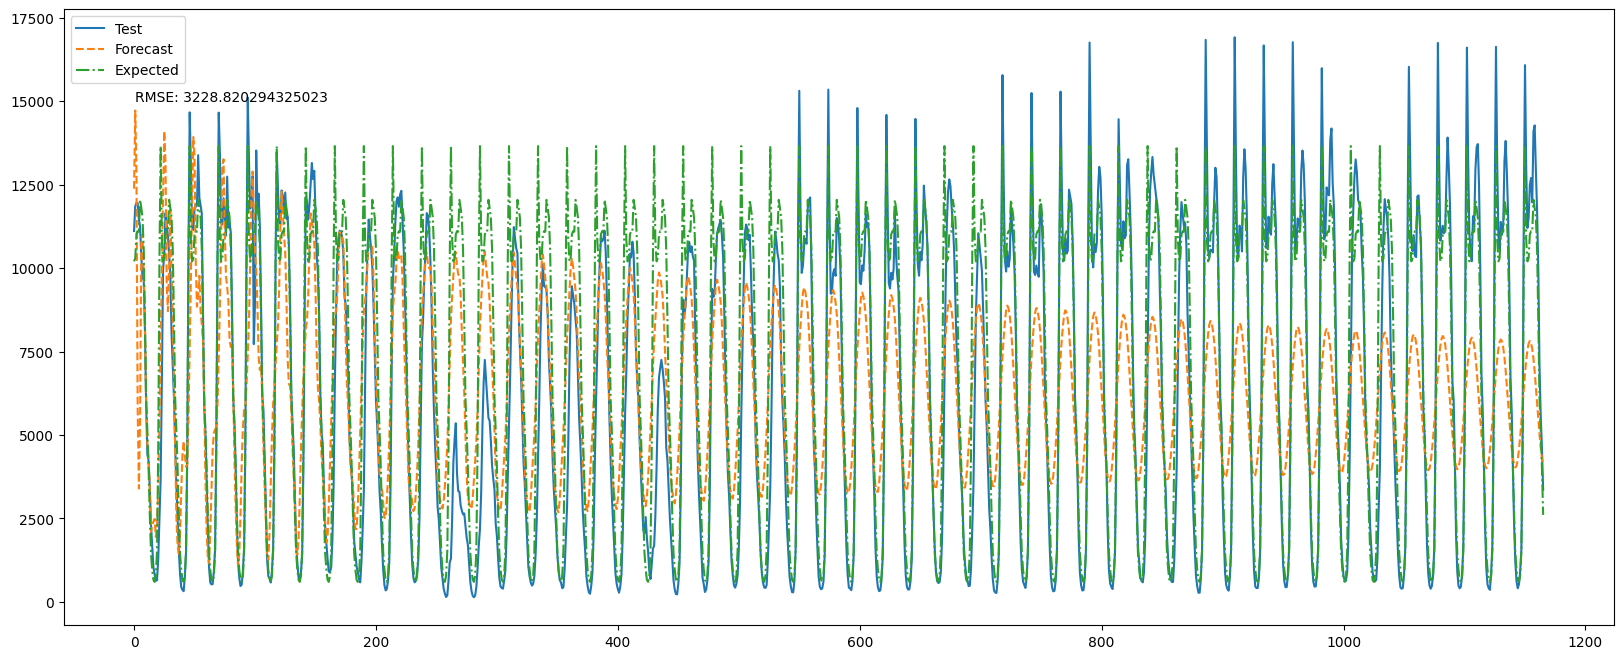

In [79]:
# Calculate the accuracy (RMSE)
mse_model=mean_squared_error(y_test,forecast)
rmse_model=mse_model**.5
# Plot the original data and forecast
plt.figure(figsize=(20,8))
#plt.plot(series, label='Original Data')
#plt.plot(range(len(series), len(series) + len(test_inds)), forecast, label='Forecast')
plt.plot(range(len(test_inds)),y_test,label='Test')
plt.plot(range(len(test_inds)),forecast,'--',label='Forecast')
plt.plot(range(len(test_inds)),expected_flow_test,'-.',label='Expected')
plt.text(.5,15000,f'RMSE: {rmse_model}')
plt.legend()
plt.show()

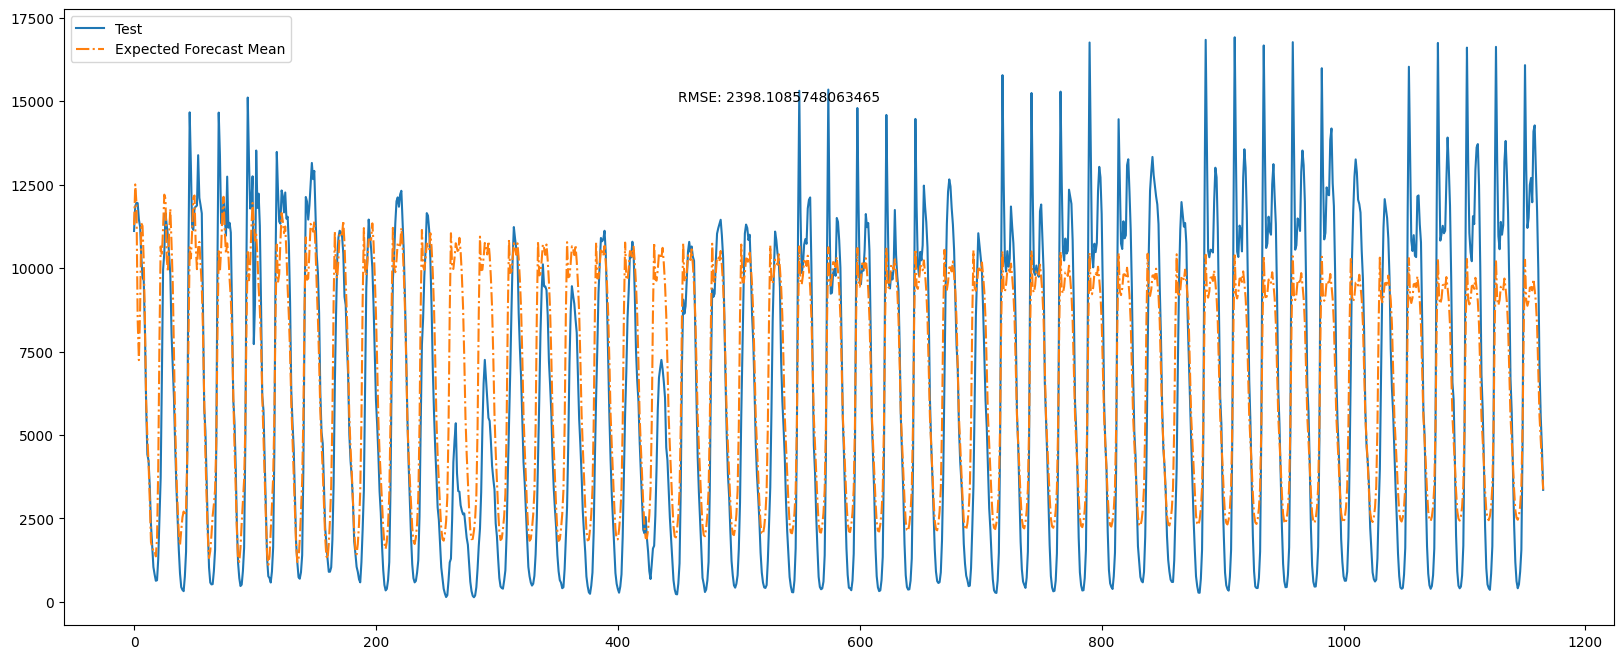

In [80]:
# Re-plotting with taking mean of expected and forecast
expected_forecast_mean=np.median([forecast,expected_flow_test],axis=0)
mse_model=mean_squared_error(y_test,expected_forecast_mean)
rmse_model=mse_model**.5
# Plot the original data and forecast
plt.figure(figsize=(20,8))
#plt.plot(series, label='Original Data')
#plt.plot(range(len(series), len(series) + len(test_inds)), forecast, label='Forecast')
plt.plot(range(len(test_inds)),y_test,label='Test')
plt.plot(range(len(test_inds)),expected_forecast_mean,'-.',label='Expected Forecast Mean')
plt.text(450,15000,f'RMSE: {rmse_model}')
plt.legend()
plt.show()

Clearly there is an improvement over the model before doing the statistical adjustment. This strategy helps us optimize computational time and resources to training the model. Other model types can be also explored

<b> XGB Regressor with time history </b>

XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that has gained immense popularity in recent years, especially for its outstanding performance in various regression and classification tasks. The XGBRegressor class in the xgboost Python library is the implementation of the XGBoost algorithm for regression problems.

<p>General Objective Function:
<br>The goal of XGBoost is to minimize the following objective function:
<br>Objective = ∑(i=1 to n) l(yi, ŷi) + ∑(k=1 to K) Ω(fk)
<br>where:
<br>l(yi, ŷi): The loss function measuring how close the model's prediction ŷi is to the true label yi.
<br>Ω(fk): A regularization term to penalize the complexity of the model, helping to prevent overfitting.
</p>

<p>Tree Ensemble Model:
<br>XGBoost uses an ensemble of decision trees to make predictions. The prediction is computed by summing the outputs of all the trees:
<br>ŷi = ∑(k=1 to K) fk(xi)
<br>where:
<br>fk represents an individual tree.
<br>xi is the input feature vector.
</p>

<p>Regularization Term:
<br>The regularization term Ω(f) helps control model complexity and is defined as:
<br>Ω(f) = γT + (1/2)λ ∑(j=1 to T) wj^2
<br>where:
<br>T: Number of leaves in the tree.
<br>wj: Leaf weights.
<br>γ and λ: Regularization parameters that control the complexity.
</p>

<p>Additive Training:
<br>XGBoost uses additive training, where it adds one tree at a time to minimize the objective function. The model prediction at step t is:
<br>ŷi(t) = ŷi(t-1) + ft(xi)
</p>

<p>Gradient Descent in Function Space:
<br>Each new tree is trained to predict the residual errors (gradients) from the previous predictions:
<br>ft(xi) = -η ∂l(yi, ŷi(t-1)) / ∂ŷi(t-1)
<br>where:
<br>η: Learning rate.
This process continues until the model converges or reaches a set number of iterations.
</p>
<p>
<br>Here are some key features and characteristics of the XGBRegressor class:

<li>Ensemble Learning: XGBoost is an ensemble learning algorithm that combines multiple decision trees to create a strong predictive model. It builds the trees in a sequential manner, with each new tree attempting to correct the errors of the previous ones.
<li>Gradient Boosting: XGBoost uses the gradient boosting technique, which iteratively adds new trees to the model to minimize the loss function. This approach allows the model to learn from its mistakes and continuously improve its predictions.
<li>Regularization: The XGBRegressor class offers several regularization parameters, such as reg_lambda (L2 regularization) and reg_alpha (L1 regularization), which help to prevent overfitting and improve the model's generalization performance.
<li>Scalability: XGBoost is designed to be highly scalable and efficient, capable of handling large-scale datasets and high-dimensional features. It can leverage parallel and distributed computing to speed up the training process.
<li>Hyperparameter Tuning: The XGBRegressor class has a wide range of hyperparameters that you can tune to optimize the model's performance for your specific problem, such as n_estimators (number of trees), max_depth (maximum depth of each tree), and learning_rate (step size for each iteration).
<li>Missing Value Handling: XGBoost has built-in support for handling missing values, which can be a common issue in real-world datasets. It can automatically learn how to best handle these missing values during the training process.
<br>
<p>
Here we try to use n_back points to predict the next few n_pred points over the length of the test data
</p>

In [81]:
n=df_sensors_in_out_timegrouped.shape[0]
n_train=int(.8*n)
train_inds=np.arange(n_train+1)
test_inds=np.arange(n_train+1,n)
print(n,n_train,train_inds[-1],test_inds[-1])

5831 4664 4664 5830


In [82]:
df_sensors_in_out_timegrouped.columns,len(df_sensors_in_out_timegrouped.columns)

(Index(['Car_in', 'Pedestrian_in', 'Cyclist_in', 'Motorbike_in', 'Bus_in',
        'OGV1_in', 'OGV2_in', 'LGV_in', 'hour', 'Total_in', 'Car_out',
        'Pedestrian_out', 'Cyclist_out', 'Motorbike_out', 'Bus_out', 'OGV1_out',
        'OGV2_out', 'LGV_out', 'Total_out', 'Total_in_minus_out',
        'Expected Flow'],
       dtype='object'),
 21)

In [83]:
X,y=df_sensors_in_out_timegrouped.reset_index().index.values.reshape(-1,1),df_sensors_in_out_timegrouped['Total_out'].values.reshape(-1,1)

In [84]:
target_col='Total_out'
n_back=72
n_pred=1
#########
len_data=X.shape[0]
data=df_sensors_in_out_timegrouped
for i in range(n_back+n_pred):
    data['shifted_'+str(i)]=data[target_col].shift(-i).values
# Create another set that shifts 'data' to the left by 'n' points
shifted_cols=[col for col in data.columns if 'shifted' in col]
non_shifted_cols=[c for c in data.columns.tolist() if 'shifted' not in c]
# Create shifted X 
X = data[shifted_cols[:n_back]].values
y=data[shifted_cols[-n_pred:]].values
print(X.shape,y.shape)

(5831, 72) (5831, 1)


In [85]:
X_train,X_test,y_train,y_test=X[train_inds],X[test_inds],y[train_inds],y[test_inds]

In [86]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4665, 72), (1166, 72), (4665, 1), (1166, 1))

In [87]:
y_test=pd.DataFrame(y_test).dropna().values
X_test=X_test[:y_test.shape[0]]
X_test.shape,y_test.shape

((1094, 72), (1094, 1))

In [88]:
# Create Pipeline and setup Grid Search
pca=PCA()
steps=[
    ('Transformer1',minmaxscaler),
    ('Transformer2',pca),
        ('Model',XGBRegressor())
        ]
# Set parameters
params = {
    'Transformer2__n_components':[1,10,30,70],
     'Model__max_depth':[1,5],
          'Model__learning_rate':[.1,.5],
             'Model__n_estimators':[2200,2500,2700]
}
pipeline=Pipeline(steps)
cross_val=GridSearchCV(estimator=pipeline,param_grid=params,cv=3)

In [89]:
model=cross_val
model.fit(X_train,y_train)
(cross_val.best_score_,cross_val.best_params_)

(0.9431217076547052,
 {'Model__learning_rate': 0.5,
  'Model__max_depth': 1,
  'Model__n_estimators': 2700,
  'Transformer2__n_components': 70})

In [90]:
forecast=model.predict(X_test)

In [91]:
# Create an expected flow array for the test data based on hours
expected_flow_test=df_sensors_in_out_timegrouped['Expected Flow'].iloc[test_inds]

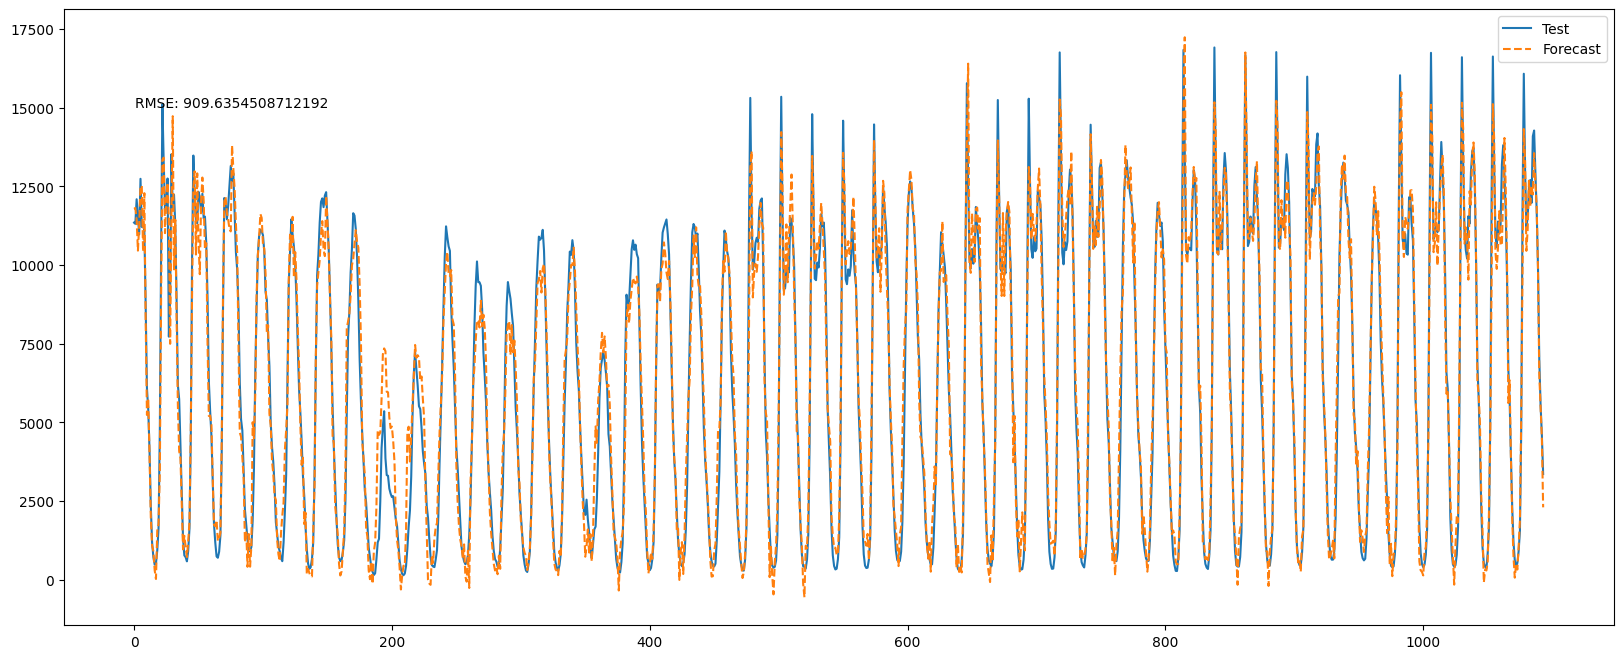

In [92]:
# Calculate the accuracy (RMSE)
mse_model=mean_squared_error(y_test[:],forecast[:len(y_test)])
rmse_model=mse_model**.5
# Plot the original data and forecast
plt.figure(figsize=(20,8))
#plt.plot(series, label='Original Data')
#plt.plot(range(len(series), len(series) + len(test_inds)), forecast, label='Forecast')
plt.plot(y_test[:],label='Test')
plt.plot(forecast[:len(y_test)],'--',label='Forecast')
#plt.plot(range(len(test_inds)),expected_flow_test,'-.',label='Expected')
plt.text(.5,15000,f'RMSE: {rmse_model}')
plt.legend()
plt.show()

<ol> 
<li> We performed XGB Regression with grid search cross validation to predict the test data and compared the prediction against the original test data
<li> We first created an array of time history where each row had n_back consecutive values in time that were used to predict another array having the next 'n_pred' points
<li> We observe that this prediction method is able to predict a lot more points with much greater accuracy (lower RMSE) and even less computing resources
<li> The XGB model is even able to predict the dips in peak traffic during the holiday season, something the ARIMA model struggled to do
<li> Hence we can conclude that the XGB Regression model performs better than an ARIMA model
</ol>

## Summary

### Data Exploration and Pre-Processing

<ol>
<li> We first imported the data from the Mill Road project from data.world
<li> We created a dataframe for analyzing the sensors data
<li> We tried to explore the data - what it looks like, its shape, and features. Whether or not it had any missing values (it didn't) and if so, how to deal with it. Fortunately it had no missing values and the data was in the required format. This is often not the case with many available data
<li> The first thing we did is visualize the sensors on the map. The sensors appeared to be clustered around the Mill Road area, broadly the Romley area next to Cambridge University and the roads leading into and out of the area.
<li> We then saw that the dataset had traffic information for different kinds like cars, buses, cyclists, motorcyclists, pedestrians, OGVs and LGVs
<li> We then determined the data frequency and saw that it is hourly.
<li> Since the data had information on both in and out traffic indicated by the 'direction' column, we converted the data to have both in and out in the same row to make traffic calculations potentially easier.
<li> Then we isolated for one sensor and plotted the distributions for the traffic data. We saw that most kinds of traffic were distributed higher during peak hours and lower at other times. One curious observation was that the net influx of traffic was negative - which means more traffic was leaving the area than entering. This seems physically unlikely.
<li> Further exploration of this shed light on that we should consider all sensors data instead of just isolating to one sensor; and this would also model a real traffic intersection better. The drawback was that it would be a large dataset making it difficult to manage and compute.
<li> Since we are looking at all sensors info, we could sum the information from different sensors at the same timestamp into one row. Therefore we grouped the data by summing the data for each timestamp. This also had the effect of drastically reducing data size. 
<li> We verified the correctness of doing this by checking with the information for the first timestamp to see that the grouping gave the same result, and verifying our hypothesis that maybe looking at all sensors together would give a better picture of the traffic. When we computed the net traffic influx, we found it to be close to zero mean. This is the data that our analysis would be performed using.
<li> One of our modeling strategies was to do a time series forecasting and augment the result using statistical hourly information (i.e. what traffic would we expect at that hour given what was observed at that hour for all days in the data). Therefore, we first studied the distributions of traffic flow by hour, and also observed the trend in the median+1std at each hour. The data showed in general that the early morning were relatively lazy, followed by high activity in late mornings through early evening, after which it slowed down again. With this, we are ready for modeling.


### Modeling

<b> Data Preparation: </b>
<li> Scaling: We explored different scaling options, including Standard, MinMax and Log. Based on plotting the effect the transformation had on the data, it was decided MinMaxScaler was the most suitable transformation.
<li> Next we split the data into training and test set. Since we are doing a time series analysis, we took the first 20% of the available data as our training and validation and next 20% as testing.

<b>ARIMA</b>
<li> We first obtained the lagged auto-correlations to explore seasonality effects. by looking at lag ACF, we determined the seasonality order (parameter q)
<li> We then looked at the PACF to see what the AR order should be. We used a moving maximum method to compare when the deviations are within expected bounds, to then decide what the value of p should be.
<li> We used these values (p,0,q) in an ARIMA model to forecast the future values (next 20%).
<li> We tried to average the forecasted values with the measure of expected flow discussed in point 12 of the Data Exploration section. Doing so drastically improved the model accuracy.
<p><br> The next step was to compare to another model, we use XGBRegression </br></p>


<b>XGB</b>
<li> First we created our X and y sets by transforming the data into arrays of lagging values (X) and leading values (y)
<li> Next we created steps for a pipeline. They involved a. MinMax Scaler, b. PCA, c. XGB Regression.
<li> We used GridSearchCV with a 3-fold cross-validation to help us obtain a model with the best transformation and hyperparameters.
<li> We then noted the best parameters and forecasted the test data with this model
<li> Finally we compared the forecast to the actual test data and determined the accuracy using RMSE
<p><br> We observed much better accuracy including the ability to follow specific trends better with the XGBRegressor model than with the ARIMA model, even after adjusting for statistically expected values. This means we can use the latter model with less re-training for longer</br></p> 

## Challenges

<li> Determining the parameter to model traffic with was the first challenge, and involved some research
<li> The time complexity of the ARIMA model was a significant hinderance to effective ARIMA modeling, achieving models with higher 'q' values took unreasonable amounts of time
<li> Finding the optimum set of parameters for the XGB pipeline took a lot of trial and error

## Improvements

<li> Exploring more complex ARIMA based time series forecasting models such as exploring the 'd' term, using SARIMAX, etc.. 
<li> Exploring strategies to reduce the training time for ARIMA and XGB
<li> Other models can be explored to compare against
<li> The model performance woud need to be continuously monitored over time with actual data to see if re-tuning is needed